# REFMAP laboratory listening test 1 analysis: Sound quality analysis

## Setup

In [3]:
# import statements
import sys
import os
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from cycler import cycler

In [4]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 9
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]

np.random.seed(303)

# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 


Set the saveplots toggle to True if plot saving is desired:

In [5]:
saveplots = True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

    # create subfolders if not already existing
    try:
        os.mkdir(os.path.join(outFigPath, "svg"))
    except FileExistsError:
        pass

    try:
        os.mkdir(os.path.join(outFigPath, "pdf"))
    except FileExistsError:
        pass


## Import data and organise

In [10]:
# import test data
fileExts = "*.csv"

# Part A
dataByStimAFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataA_ByStim.csv",
                                                      caption=r"Open refmap_listest1_testdataA_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestA = pd.read_csv(dataByStimAFilePath, index_col=0)

# Part B
dataByStimBFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataB_ByStim.csv",
                                                       caption=r"Open refmap_listest1_testdataB_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestB = pd.read_csv(dataByStimBFilePath, index_col=0)

# Auxiliary data

auxDataByStimFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_auxdata.csv",
                                                         caption=r"Open refmap_listest1_auxdata.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
auxData =  pd.read_csv(auxDataByStimFilePath, index_col=0)

DON'T RUN THE NEXT BLOCK UNLESS NEEDING TIME-DEPENDENT DATA - EXCESSIVE LOADING TIME

In [ ]:
## !!!ONLY RUN IF NEEDED - TIME-INTENSIVE LOADING BLOCK!!!

# import SQM time-dependent data
fileExts = "*.xlsx"
filelist = list(QFileDialog.getOpenFileNames(filter=fileExts,
                                             caption=r"Select SQM analysis files in: \03 Experiment\Experiment 1\Analysis\ArtemiS\Output_new"))[0]
filelist.sort()
filenames = [filepath.split('/')[-1] for filepath in filelist]
A1_SQM = pd.read_excel(io=filelist[0], sheet_name=None)
A2_SQM = pd.read_excel(io=filelist[1], sheet_name=None)
H520_F_1_SQM = pd.read_excel(io=filelist[2], sheet_name=None)
H520_L_1_SQM = pd.read_excel(io=filelist[3], sheet_name=None)
H520_T_1_SQM = pd.read_excel(io=filelist[4], sheet_name=None)
M300_F_1_SQM = pd.read_excel(io=filelist[5], sheet_name=None)
M300_L_1_SQM = pd.read_excel(io=filelist[6], sheet_name=None)
M300_T_1_SQM = pd.read_excel(io=filelist[7], sheet_name=None)
T150_F_1_SQM = pd.read_excel(io=filelist[8], sheet_name=None)
T150_L_1_SQM = pd.read_excel(io=filelist[9], sheet_name=None)
T150_T_1_SQM = pd.read_excel(io=filelist[10], sheet_name=None)

## Stimuli sound quality analysis

### Time-aggregated

Below is a function that generates a radar (spider) plot with varying axis scalings.

In [6]:
def spider(df, *, id_column, title=None, max_values=None, padding=1.25, axsize=12, labelsize=12, legsize=12, palette=None,
           savefigpath=False, savefigfmt='svg'):
    categories = df._get_numeric_data().columns.tolist()
    data = df[categories].to_dict(orient='list')
    ids = df[id_column].tolist()
    if max_values is None:
        max_values = {key: padding*max(value) for key, value in data.items()}
    else:
        keys = [key for key in data.keys()]
        values =  [max_value for max_value in max_values]
        max_values = dict(map(lambda i, j: (i, j), keys, values))
    
    normalized_data = {key: np.array(value) / max_values[key] for key, value in data.items()}
    num_vars = len(data.keys())
    tiks = list(data.keys())
    tiks += tiks[:1]
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist() + [0]
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    if palette is None:
        pass
    else:
        try:
            ax.set_prop_cycle(cycler(color=palette))
        except TypeError:
            raise TypeError


    for ii, model_name in enumerate(ids):
        values = [normalized_data[key][ii] for key in data.keys()]
        actual_values = [data[key][ii] for key in data.keys()]
        values += values[:1]  # Close the plot for a better look
        ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.15)
        
        for _x, _y, t in zip(angles, values, actual_values):
            t = f'{t:.3f}' if isinstance(t, float) else str(t)
            ax.text(_x, _y, t, size=labelsize)

            
    ax.fill(angles, np.ones(num_vars + 1), alpha=0.01)
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(tiks, fontsize=axsize)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=legsize)
    if title is not None: plt.suptitle(title)
    if savefigpath != False:
        try:
            plt.savefig(savefigpath, format=savefigfmt)
        except ValueError:
            raise ValueError
    plt.show()

In [47]:
# prepare subdata frame 
#df_SQM = dataByStimTestA.loc[(dataByStimTestA['AmbientEnv'] == "Park") &
#                             (dataByStimTestA['UASLAeq'] == "60"),
#                             ['UASType', 'UASOperation',
#                              'UASLoudECMAHMSPowAvgBin', 'UASSharpAuresISO305ExMaxLR',
#                              'UASTonalIntAvgMaxLR', 'UASFluctOV10ExMaxLR',
#                              'UASRoughFZ05ExMaxLR', 'UASImpulsHMSAvgMaxLR']]

df_SQM = auxData.loc[(auxData['UASLAeq'] == 60) &
                     (auxData['SessionPart'] == 'A'), ['UASType', 'UASOperation',
                              'LoudECMAHMSPowAvgBin', 'SharpAuresISO305ExMaxLR',
                              'TonalInt05ExMaxLR', 'FluctOV10ExMaxLR',
                              'RoughFZ05ExMaxLR', 'ImpulsHMSAvgMaxLR']]

max_values = np.round(np.max(df_SQM.iloc[:, 2:], axis=0)*1.1, 3)


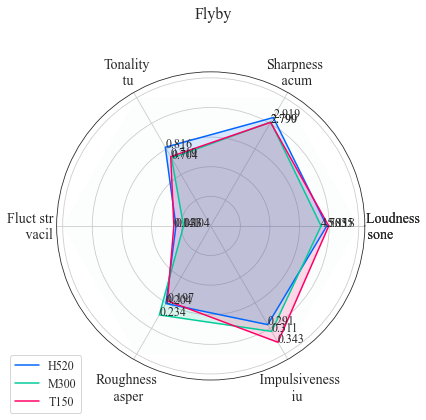

In [48]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[3]].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = os.path.join(outFigPath, "UASSQMFlyby.svg")
else:
    savefigpath = False

spider(
    data,
    id_column='UASType',
    title='Flyby',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath)


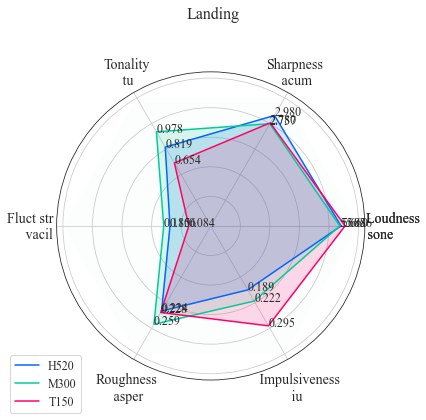

In [49]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[3]].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = os.path.join(outFigPath, "UASSQMLanding.svg")
else:
    savefigpath = False

spider(
    data,
    id_column='UASType',
    title='Landing',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath)


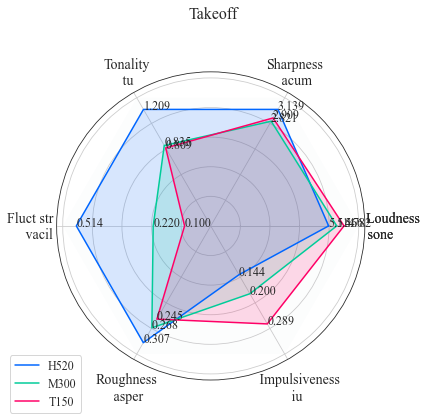

In [50]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[3]].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = os.path.join(outFigPath, "UASSQMTakeoff.svg")
else:
    savefigpath = False

spider(
    data,
    id_column='UASType',
    title='Takeoff',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath)

### Time-aggregated (repeat)

Radar analysis repeated with ISO 532-3 loudness

In [51]:
# prepare subdata frame 
#df_SQM = dataByStimTestA.loc[(dataByStimTestA['AmbientEnv'] == "Park") &
#                              (dataByStimTestA['UASLAeq'] == "60"),
#                              ['UASType', 'UASOperation',
#                               'UASLoudISO3PowAvgBin', 'UASSharpAuresISO305ExMaxLR',
#                               'UASTonalECMAHMSAvgMaxLR', 'UASFluctHMS10ExBin',
#                               'UASRoughECMAHMS10ExBin', 'UASImpulsHMSAvgMaxLR']]

df_SQM = auxData.loc[(auxData['UASLAeq'] == 60) &
                     (auxData['SessionPart'] == 'A'), ['UASType', 'UASOperation',
                              'LoudISO3PowAvgBin', 'SharpAuresISO305ExMaxLR',
                              'TonalInt05ExMaxLR', 'FluctOV10ExMaxLR',
                              'RoughFZ05ExMaxLR', 'ImpulsHMSAvgMaxLR']]

max_values = np.round(np.max(df_SQM.iloc[:, 2:], axis=0)*1.1, 3)


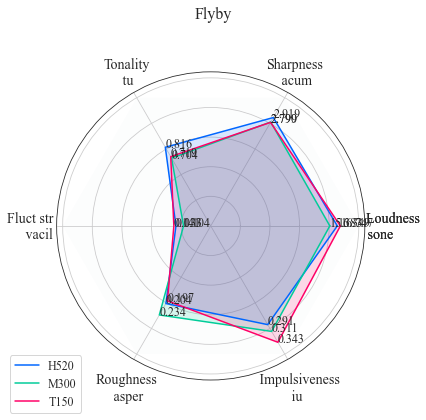

In [52]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[3]].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[7]].values, 3)
    })


if saveplots:
    savefigpath = os.path.join(outFigPath, "UASSQMFlybyNISO3.svg")
else:
    savefigpath = False
    
spider(
    data,
    id_column='UASType',
    title='Flyby',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath)


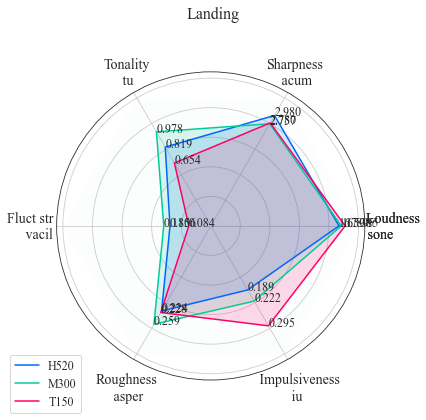

In [54]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[3]].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = os.path.join(outFigPath, "UASSQMLandingNISO3.svg")
else:
    savefigpath = False

spider(
    data,
    id_column='UASType',
    title='Landing',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath)

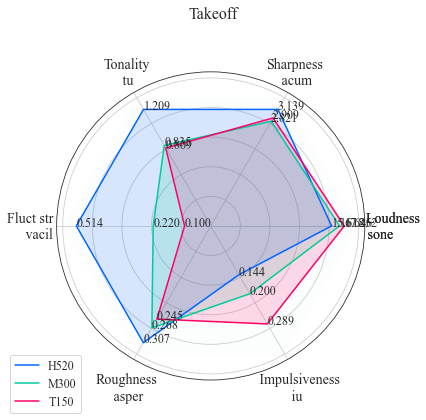

In [55]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[3]].values, 3),
        'Tonality\n tu\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = os.path.join(outFigPath, "UASSQMTakeoffNISO3.svg")
else:
    savefigpath = False

spider(data,
       id_column='UASType',
       title='Takeoff',
       max_values=max_values,
       padding=1.15,
       axsize=14,
       palette=mycolours,
       savefigpath=savefigpath)

### Time-aggregated (repeat)

Radar analysis repeated with ISO 532-3 loudness and tonal loudness instead of (integrated) tonality

In [56]:
# prepare subdata frame 
#df_SQM = dataByStimTestA.loc[(dataByStimTestA['AmbientEnv'] == "Park") &
#                              (dataByStimTestA['UASLAeq'] == "60"),
#                              ['UASType', 'UASOperation',
#                               'UASLoudISO3PowAvgBin', 'UASSharpAuresISO305ExMaxLR',
#                               'UASTonalECMAHMSAvgMaxLR', 'UASFluctHMS10ExBin',
#                               'UASRoughECMAHMS10ExBin', 'UASImpulsHMSAvgMaxLR']]

df_SQM = auxData.loc[(auxData['UASLAeq'] == 60) &
                     (auxData['SessionPart'] == 'A'), ['UASType', 'UASOperation',
                              'LoudISO3PowAvgBin', 'SharpAuresISO305ExMaxLR',
                              'TonLdECMAHMSPowAvgBin', 'FluctOV10ExMaxLR',
                              'RoughFZ05ExMaxLR', 'ImpulsHMSAvgMaxLR']]

max_values = np.round(np.max(df_SQM.iloc[:, 2:], axis=0)*1.1, 3)


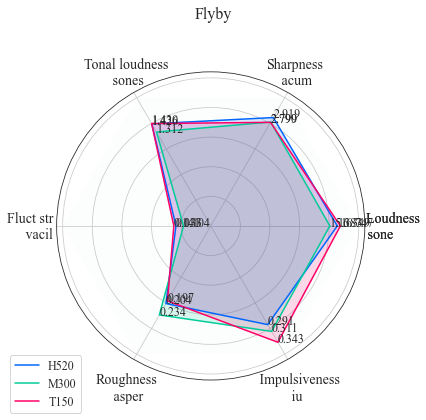

In [57]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[3]].values, 3),
        'Tonal loudness\n sones\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Flyby'), df_SQM.columns[7]].values, 3)
    })


if saveplots:
    savefigpath = os.path.join(outFigPath, "UASSQMFlybyNISO3TLd.svg")
else:
    savefigpath = False
    
spider(
    data,
    id_column='UASType',
    title='Flyby',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath)


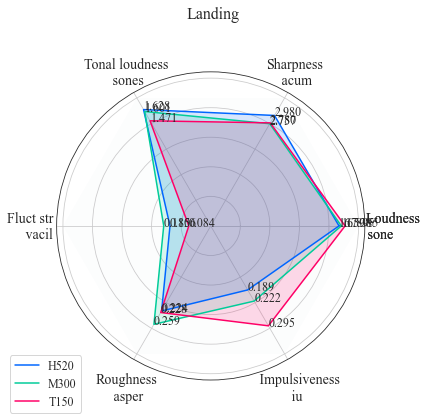

In [58]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[3]].values, 3),
        'Tonal loudness\n sones\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Landing'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = os.path.join(outFigPath, "UASSQMLandingNISO3TLd.svg")
else:
    savefigpath = False

spider(
    data,
    id_column='UASType',
    title='Landing',
    max_values=max_values,
    padding=1.15,
    axsize=14,
    palette=mycolours,
    savefigpath=savefigpath)

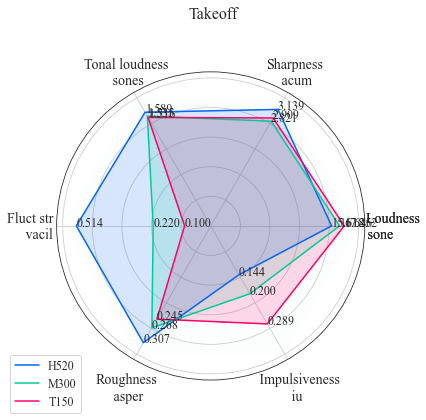

In [59]:
data=pd.DataFrame({
        'UASType': df_SQM['UASType'].unique(),
        '        Loudness\n sone': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[2]].values, 3),
        'Sharpness\n acum\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[3]].values, 3),
        'Tonal loudness\n sones\n': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[4]].values, 3),
        'Fluct str       \n vacil   ': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[5]].values, 3),
        '\n\nRoughness\n asper': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[6]].values, 3),
        '\n\n   Impulsiveness\n iu': np.round(df_SQM.loc[(df_SQM['UASOperation'] == 'Takeoff'), df_SQM.columns[7]].values, 3)
    })

if saveplots:
    savefigpath = os.path.join(outFigPath, "UASSQMTakeoffNISO3TLd.svg")
else:
    savefigpath = False

spider(data,
       id_column='UASType',
       title='Takeoff',
       max_values=max_values,
       padding=1.15,
       axsize=14,
       palette=mycolours,
       savefigpath=savefigpath)

## Loudness/level comparison

In [65]:
def lowess_with_confidence_bounds(
    data, x, y, xvals=None, n_boot=1000, conf_interval=0.95, lowess_kw={}):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """

    x = data[x]
    y = data[y]

    if xvals is None:
        xvals = x.sort_values().values
    
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=xvals, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((n_boot, len(xvals)))
    for i in range(n_boot):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x.values[sample]
        sampled_y = y.values[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=xvals, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(n_boot * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top


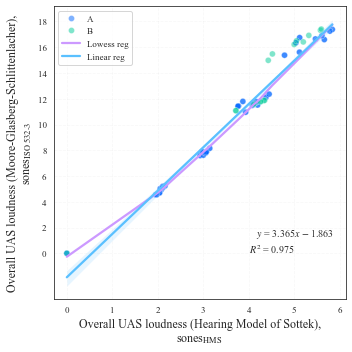

In [94]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO3PowAvgBin'], sm.add_constant(data['UASLoudECMAHMSPowAvgBin']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudECMAHMSPowAvgBin', y='UASLoudISO3PowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudECMAHMSPowAvgBin', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg")
sns.regplot(data=data, x='UASLoudECMAHMSPowAvgBin', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[6], lowess=False, label="Linear reg")
ax.grid(alpha=0.15, linestyle='--')
ax.set(xlabel="Overall UAS loudness (Hearing Model of Sottek)," + "\n" + r"sones$_\text{HMS}$",
       ylabel="Overall UAS loudness (Moore-Glasberg-Schlittenlacher)," + "\n" + r"sones$_\text{ISO 532-3}$",
       xticks=range(0, 7), yticks=range(0, 20, 2))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=4, y=0, s=r"$R^2$ = " + str(round(res.rsquared, 3)))
ax.text(x=4, y=1.3,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" +" " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()
plt.show()

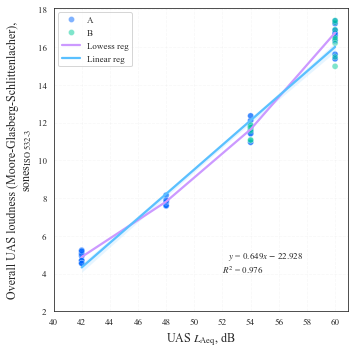

In [226]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])
data = data[data['UASLAeq'] != 'No UAS']
data['UASLAeq'] = data['UASLAeq'].astype(float)

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO3PowAvgBin'], sm.add_constant(data['UASLAeq']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLAeq', y='UASLoudISO3PowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLAeq', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg")
sns.regplot(data=data, x='UASLAeq', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[6], lowess=False, label="Linear reg")
ax.grid(alpha=0.15, linestyle='--')
ax.set(xlabel=r"UAS $L_\text{Aeq}$, dB",
       ylabel="Overall UAS loudness (Moore-Glasberg-Schlittenlacher)," + "\n" + r"sones$_\text{ISO 532-3}$",
       xticks=range(40, 62, 2), yticks=range(2, 20, 2))
ax.text(x=52, y=4, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=52, y=4.8,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()
plt.show()

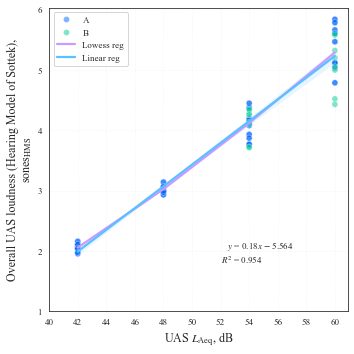

In [228]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])
data = data[data['UASLAeq'] != 'No UAS']
data['UASLAeq'] = data['UASLAeq'].astype(float)

# fit linear regression model 
mod = sm.OLS(data['UASLoudECMAHMSPowAvgBin'], sm.add_constant(data['UASLAeq']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLAeq', y='UASLoudECMAHMSPowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLAeq', y='UASLoudECMAHMSPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg")
sns.regplot(data=data, x='UASLAeq', y='UASLoudECMAHMSPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[6], lowess=False, label="Linear reg")
ax.grid(alpha=0.15, linestyle='--')

ax.set(xlabel=r"UAS $L_\text{Aeq}$, dB",
       ylabel="Overall UAS loudness (Hearing Model of Sottek)," + "\n" + r"sones$_\text{HMS}$",
       xticks=range(40, 62, 2), yticks=range(1, 7))
ax.text(x=52, y=1.8, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=52, y=2.05,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()
plt.show()

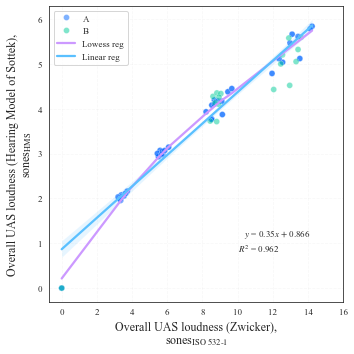

In [229]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])

# fit linear regression model 
mod = sm.OLS(data['UASLoudECMAHMSPowAvgBin'], sm.add_constant(data['UASLoudISO1PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudECMAHMSPowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudECMAHMSPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg")
sns.regplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudECMAHMSPowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[6], lowess=False, label="Linear reg")
ax.grid(alpha=0.15, linestyle='--')
ax.set(ylabel="Overall UAS loudness (Hearing Model of Sottek)," + "\n" + r"sones$_\text{HMS}$",
       xlabel="Overall UAS loudness (Zwicker)," + "\n" + r"sones$_{\text{ISO 532-1}}$",
       yticks=range(0, 7), xticks=range(0, 18, 2))
ax.text(x=10, y=0.8, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=10, y=1.15,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()
plt.show()

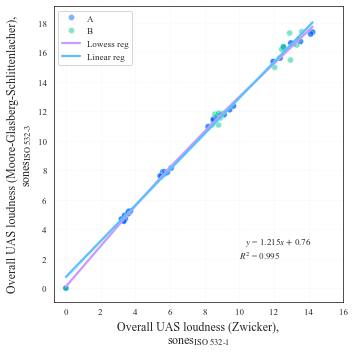

In [230]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO3PowAvgBin'], sm.add_constant(data['UASLoudISO1PowAvgMaxLR']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudISO3PowAvgBin', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg")
sns.regplot(data=data, x='UASLoudISO1PowAvgMaxLR', y='UASLoudISO3PowAvgBin',
            scatter=False, seed=303, n_boot=2000, color=mycolours[6], lowess=False, label="Linear reg")
ax.grid(alpha=0.15, linestyle='--')
ax.set(xlabel="Overall UAS loudness (Zwicker)," + "\n" + r"sones$_\text{ISO 532-1}$",
       ylabel="Overall UAS loudness (Moore-Glasberg-Schlittenlacher)," + "\n" + r"sones$_\text{ISO 532-3}$",
       xticks=range(0, 18, 2), yticks=range(0, 20, 2))
ax.text(x=10, y=2, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=10, y=3,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()
plt.show()

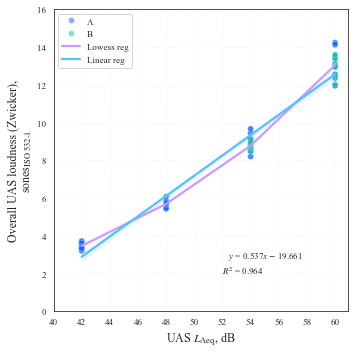

In [231]:
fig, ax = plt.subplots(figsize=(5, 5))

data = pd.concat([dataByStimTestA, dataByStimTestB])
data = data[data['UASLAeq'] != 'No UAS']
data['UASLAeq'] = data['UASLAeq'].astype(float)

# fit linear regression model 
mod = sm.OLS(data['UASLoudISO1PowAvgMaxLR'], sm.add_constant(data['UASLAeq']), hasconst=True)
res = mod.fit()

sns.scatterplot(data=data, x='UASLAeq', y='UASLoudISO1PowAvgMaxLR', hue='SessionPart',
                palette=mycolours[0:2], alpha=0.5, ax=ax)
sns.regplot(data=data, x='UASLAeq', y='UASLoudISO1PowAvgMaxLR',
            scatter=False, seed=303, n_boot=2000, color=mycolours[5], lowess=True, label="Lowess reg")
sns.regplot(data=data, x='UASLAeq', y='UASLoudISO1PowAvgMaxLR',
            scatter=False, seed=303, n_boot=2000, color=mycolours[6], lowess=False, label="Linear reg")
ax.grid(alpha=0.15, linestyle='--')
ax.set(xlabel=r"UAS $L_\text{Aeq}$, dB",
       ylabel="Overall UAS loudness (Zwicker)," + "\n" + r"sones$_\text{ISO 532-1}$",
       xticks=range(40, 62, 2), yticks=range(0, 18, 2))
ax.text(x=52, y=2, s=r"$R^2$ = " + str(round(res.rsquared, 3)))

# generate string for intercept sign
if np.sign(res.params.iloc[0]) < 0:
    icept = r"$ - $"
else:
    icept = r"$ + $"

ax.text(x=52, y=2.8,
        s=r"   $y$ = " + str(round(res.params.iloc[1], 3)) + r"$x$" + " " + icept + " " + str(abs(round(res.params.iloc[0], 3))))
ax.legend()
plt.show()

### Psychoacoustic annoyance analysis

Create a function to calculate psychoacoustic annoyance

In [287]:
def psychAnnoy(loudness, sharpness, roughness, fluctstr=None, tonality=None, impulsivity=None, method='widmann'):

    # initialise arrays
    omS = np.zeros(len(sharpness))
    
    if method in ['widmann', 'di', 'more', 'torija', 'willemsen']:

        if method.lower() == 'willemsen':

            pa = 27.73 + 1.24*impulsivity + 0.86*loudness*sharpness + 1.81*roughness

        else:

            omS[sharpness > 1.75] = 0.25*(sharpness[sharpness > 1.75] - 1.75)*np.log10(loudness[sharpness > 1.75] + 10)
        
            omFR = (2.18/loudness**0.4)*(0.4*fluctstr + 0.6*roughness)
            
            if method.lower() == 'widmann':
                g0 = 0
                gS = 1
                gFR = 1
                gT = 0
                gI = 0
        
                omT = 0
                omI = 0
        
            elif method.lower() == 'more':

                g0 = -0.16
                gS = 11.48
                gFR = 0.84
                gT = 1.25
                gI = 0

                omT = (1 - np.exp(-0.29*loudness))*(1 - np.exp(-5.49*tonality))
                omI = 0
            
            elif method.lower() == 'di':
                g0 = 0
                gS = 1
                gFR = 1
                gT = 1
                gI = 0

                omT = 6.41/loudness**0.52*tonality
                omI = 0

            elif method.lower() == 'torija':
                g0 = 103.08
                gS = 339.49
                gFR = 121.88
                gT = 77.2 
                gI = 29.29

                omT = (1 - np.exp(-0.29*loudness))*(1 - np.exp(-5.49*tonality))
                omI = 0.075*impulsivity/loudness**-1.334

        sqm = np.maximum(0, g0 + gS*omS**2 + gFR*omFR**2 + gT*omT**2 + gI*omI**2)

        pa = loudness*(1 + np.sqrt(sqm))

    else:
        raise ValueError("Input 'method' must be one of 'widmann', 'di', 'more', 'torija', 'willemsen'")

    return pa

Function for rounding (expected behaviour)

In [269]:
def roundTrad(val, digits):
    """..."""
    return round(val+10**(-len(str(val))-1), digits)

Open additional metric calculations file and obtain calculated values.

Aures sharpness with ISO 532-1 loudness, 50th percentile

In [29]:
fileExts = "*.xlsx"

dataFilePath = list(QFileDialog.getOpenFileName(filter=r"Sharpness_Time_ISO_532-1_Aures.xlsx",
                                                caption=r"Sharpness_Time_ISO_532-1_Aures.xlsx in: \03 Experiment\Experiment 1\Analysis\ArtemiS\Added_metrics"))[0]
workbookdata0 = pd.read_excel(io=dataFilePath, sheet_name=None)

files = list()
sharpness50 = list()
for ii, sheet in enumerate(workbookdata0.keys()):
    file = workbookdata0[sheet].columns[5].split(sep='\'')[1]
    
    if file.find("YnTy") != -1:
        file = file.replace("YnTy", "H520")

    if file.find(".wav_Pa.wav") != -1:
        file = file.replace(".wav_Pa.wav", "_Pa.wav")

    sharpness = pd.DataFrame(workbookdata0[sheet].iloc[14:, 1:3].values,
                             columns=workbookdata0[sheet].iloc[13, 1:3],
                             index=workbookdata0[sheet].iloc[14:, 0])

    files.append(file)
    sharpness50.append(sharpness.loc[np.tile((sharpness.index.values > 0.5),
                                             (2, 1)).transpose()
                                     & np.tile((sharpness.index.values
                                                < sharpness.index.values.max() - 0.5),
                                               (2, 1)).transpose()].quantile(q=0.50, axis=0).max())

sharpAuISO150Ex = pd.DataFrame(data=sharpness50, index=files, columns=["SharpAuresISO150ExMaxLR"])

del workbookdata0

von Bismarck sharpness with ISO 532-1 loudness, 95th percentile

In [72]:
fileExts = "*.xlsx"

# Part A
dataFilePath = list(QFileDialog.getOpenFileName(filter=r"Sharpness_Time_ISO_532-1_von_Bismarck.xlsx",
                                                caption=r"Sharpness_Time_ISO_532-1_von_Bismarck.xlsx in: \03 Experiment\Experiment 1\Analysis\ArtemiS\Added_metrics"))[0]
workbookdata1 = pd.read_excel(io=dataFilePath, sheet_name=None)

files = list()
sharpness05 = list()
for ii, sheet in enumerate(workbookdata1.keys()):
    file = workbookdata1[sheet].columns[5].split(sep='\'')[1]
    
    if file.find("YnTy") != -1:
        file = file.replace("YnTy", "H520")

    if file.find(".wav_Pa.wav") != -1:
        file = file.replace(".wav_Pa.wav", "_Pa.wav")

    sharpness = pd.DataFrame(workbookdata1[sheet].iloc[14:, 1:3].values,
                             columns=workbookdata1[sheet].iloc[13, 1:3],
                             index=workbookdata1[sheet].iloc[14:, 0])

    files.append(file)
    sharpness05.append(sharpness.loc[np.tile((sharpness.index.values > 0.5),
                                             (2, 1)).transpose()
                                     & np.tile((sharpness.index.values
                                                < sharpness.index.values.max() - 0.5),
                                               (2, 1)).transpose()].quantile(q=0.95, axis=0).max())

sharpvBISO105Ex = pd.DataFrame(data=sharpness05, index=files, columns=["SharpVonBisISO105ExMaxLR"])

del workbookdata1

DIN 45692 sharpness 95th percentile

In [74]:
fileExts = "*.xlsx"

# Part A
dataFilePath = list(QFileDialog.getOpenFileName(filter=r"Sharpness_Time_DIN_45631_A1_DIN_45692.xlsx",
                                                caption=r"Sharpness_Time_DIN_45631_A1_DIN_45692.xlsx in: \03 Experiment\Experiment 1\Analysis\ArtemiS\Added_metrics"))[0]
workbookdata2 = pd.read_excel(io=dataFilePath, sheet_name=None)

files = list()
sharpness05 = list()
for ii, sheet in enumerate(workbookdata2.keys()):
    file = workbookdata2[sheet].columns[5].split(sep='\'')[1]
    
    if file.find("YnTy") != -1:
        file = file.replace("YnTy", "H520")

    if file.find(".wav_Pa.wav") != -1:
        file = file.replace(".wav_Pa.wav", "_Pa.wav")

    sharpness = pd.DataFrame(workbookdata2[sheet].iloc[14:, 1:3].values,
                             columns=workbookdata2[sheet].iloc[13, 1:3],
                             index=workbookdata2[sheet].iloc[14:, 0])

    files.append(file)
    sharpness05.append(sharpness.loc[np.tile((sharpness.index.values > 0.5),
                                             (2, 1)).transpose()
                                     & np.tile((sharpness.index.values
                                                < sharpness.index.values.max() - 0.5),
                                               (2, 1)).transpose()].quantile(q=0.95, axis=0).max())

sharpDIN4569205Ex = pd.DataFrame(data=sharpness05, index=files, columns=["SharpDIN4569205ExMaxLR"])

del workbookdata2

Cycle over each sharpness method and merge the overall, UAS only and ambient only results into data

In [84]:
# Generate UAS only and ambient only values and merge into data
for data in [sharpAuISO150Ex, sharpvBISO105Ex, sharpDIN4569205Ex]:
    mask = data.index.str.find("A_") != -1
    UASonlyPtA1 = data.loc[mask, :].copy()
    UASonlyPtA1 = UASonlyPtA1.add_prefix("UAS", axis=1)
    UASonlyPtA2 = UASonlyPtA1.copy()
    UASonlyPtA1['newindex'] = [file.replace("A_", "A1_")
                               for file in list(UASonlyPtA1.index)]
    UASonlyPtA1.set_index('newindex', inplace=True)
    UASonlyPtA2['newindex'] = [file.replace("A_", "A2_")
                               for file in list(UASonlyPtA2.index)]
    UASonlyPtA2.set_index('newindex', inplace=True)
    
    UASonlyPtA = pd.concat([UASonlyPtA1, UASonlyPtA2], axis=0)
    
    # Part B UAS only
    mask = data.index.str.find("B_") != -1
    UASonlyPtB = data.loc[mask, :].copy()
    UASonlyPtB = UASonlyPtB.add_prefix("UAS", axis=1)
    UASonlyPtB['newindex'] = [file.replace("B_", "B2_")
                              for file in list(UASonlyPtB.index)]
    UASonlyPtB.set_index('newindex', inplace=True)
    
    # concatenate UAS only
    UASonly = pd.concat([UASonlyPtA, UASonlyPtB], axis=0)
    
    # Part A1 ambient only
    mask = data.index.str.find("A1_CALBIN") != -1
    AmbonlyPtA1 = data.loc[mask, :].copy()
    AmbonlyPtA1 = AmbonlyPtA1.add_prefix("Amb", axis=1)
    AmbonlyPtA1 = AmbonlyPtA1.loc[AmbonlyPtA1.index.repeat(
                                  sum(data.index.str.find("A_") != -1) + 1)]
    AmbonlyPtA1['newindex'] = UASonlyPtA1.index.union(data.index[data.index.str.find("A1_CALBIN") != -1])
    AmbonlyPtA1.set_index('newindex', inplace=True)
    
    # Part A2 ambient only
    mask = data.index.str.find("A2_CALBIN") != -1
    AmbonlyPtA2 = data.loc[mask, :].copy()
    AmbonlyPtA2 = AmbonlyPtA2.add_prefix("Amb", axis=1)
    AmbonlyPtA2 = AmbonlyPtA2.loc[AmbonlyPtA2.index.repeat(
                                  sum(data.index.str.find("A_") != -1) + 1)]
    AmbonlyPtA2['newindex'] = UASonlyPtA2.index.union(data.index[data.index.str.find("A2_CALBIN") != -1])
    AmbonlyPtA2.set_index('newindex', inplace=True)
    
    AmbonlyPtA = pd.concat([AmbonlyPtA1, AmbonlyPtA2], axis=0)
    
    # Part B ambient only
    mask = data.index.str.find("B2_CALBIN") != -1
    AmbonlyPtB = data.loc[mask, :].copy()
    AmbonlyPtB = AmbonlyPtB.add_prefix("Amb", axis=1)
    AmbonlyPtB = AmbonlyPtB.loc[AmbonlyPtB.index.repeat(
                                sum(data.index.str.find("B_") != -1) + 1)]
    AmbonlyPtB['newindex'] = UASonlyPtB.index.union(data.index[data.index.str.find("B2_CALBIN") != -1])
    AmbonlyPtB.set_index('newindex', inplace=True)
    
    # concatenate UAS only
    Ambonly = pd.concat([AmbonlyPtA, AmbonlyPtB], axis=0)
    
    # concatenate UAS only and ambient only
    UASAmb = pd.concat([UASonly, Ambonly], axis=1)
    
    # replace nans with 0
    UASAmb.fillna(0, inplace=True)
    
    # merge together
    allcols = data.merge(right=UASAmb, how='inner', left_index=True, right_index=True)

    # merge into results
    dataByStimTestA = dataByStimTestA.merge(right=allcols, how='inner', left_index=True, right_index=True)
    dataByStimTestB = dataByStimTestB.merge(right=allcols, how='inner', left_index=True, right_index=True)



#### Widmann psychoacoustic annoyance

##### Part A

In [288]:
# calculate overall psychoacoustic annoyance
paPtAWidmann_1 = psychAnnoy(loudness=dataByStimTestA['LoudISO105ExMaxLR'],
                            sharpness=dataByStimTestA['SharpVonBisISO105ExMaxLR'],
                            roughness=dataByStimTestA['RoughFZ05ExMaxLR'],
                            fluctstr=dataByStimTestA['FluctFZ05ExMaxLR'],
                            tonality=None,
                            impulsivity=None,
                            method='widmann')
paMedPtAWidmann_1 = paPtAWidmann_1/paPtAWidmann_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAWidmann_1 = paPtAWidmann_1/paPtAWidmann_1.max()*dataByStimTestA['AnnoyMean'].max()

In [289]:
# calculate UAS only psychoacoustic annoyance
paPtAUASWidmann_1 = psychAnnoy(loudness=dataByStimTestA['UASLoudISO105ExMaxLR'],
                               sharpness=dataByStimTestA['UASSharpVonBisISO105ExMaxLR'],
                               roughness=dataByStimTestA['UASRoughFZ05ExMaxLR'],
                               fluctstr=dataByStimTestA['UASFluctFZ05ExMaxLR'],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtAUASWidmann_1.fillna(0, inplace=True)
paMedPtAUASWidmann_1 = paPtAUASWidmann_1/paPtAUASWidmann_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASWidmann_1 = paPtAUASWidmann_1/paPtAUASWidmann_1.max()*dataByStimTestA['AnnoyMean'].max()

In [290]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbWidmann_1 = np.sqrt(paPtAUASWidmann_1**2 + psychAnnoy(loudness=dataByStimTestA['AmbLoudISO105ExMaxLR'],
                                                      sharpness=dataByStimTestA['AmbSharpVonBisISO105ExMaxLR'],
                                                      roughness=dataByStimTestA['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestA['AmbFluctFZ05ExMaxLR'],
                                                      tonality=None,
                                                      impulsivity=None,
                                                      method='widmann')**2)
paMedPtAUASAmbWidmann_1 = paPtAUASAmbWidmann_1/paPtAUASAmbWidmann_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASAmbWidmann_1 = paPtAUASAmbWidmann_1/paPtAUASAmbWidmann_1.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [291]:
# calculate overall psychoacoustic annoyance
paPtBWidmann_1 = psychAnnoy(loudness=dataByStimTestB['LoudISO105ExMaxLR'],
                            sharpness=dataByStimTestB['SharpVonBisISO105ExMaxLR'],
                            roughness=dataByStimTestB['RoughFZ05ExMaxLR'],
                            fluctstr=dataByStimTestB['FluctFZ05ExMaxLR'],
                            tonality=None,
                            impulsivity=None,
                            method='widmann')
paMedPtBWidmann_1 = paPtBWidmann_1/paPtBWidmann_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBWidmann_1 = paPtBWidmann_1/paPtBWidmann_1.max()*dataByStimTestB['AnnoyMean'].max()

In [292]:
# calculate UAS only psychoacoustic annoyance
paPtBUASWidmann_1 = psychAnnoy(loudness=dataByStimTestB['UASLoudISO105ExMaxLR'],
                               sharpness=dataByStimTestB['UASSharpVonBisISO105ExMaxLR'],
                               roughness=dataByStimTestB['UASRoughFZ05ExMaxLR'],
                               fluctstr=dataByStimTestB['UASFluctFZ05ExMaxLR'],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtBUASWidmann_1.fillna(0, inplace=True)
paMedPtBUASWidmann_1 = paPtBUASWidmann_1/paPtBUASWidmann_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASWidmann_1 = paPtBUASWidmann_1/paPtBUASWidmann_1.max()*dataByStimTestB['AnnoyMean'].max()

In [293]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbWidmann_1 = np.sqrt(paPtBUASWidmann_1**2 + psychAnnoy(loudness=dataByStimTestB['AmbLoudISO105ExMaxLR'],
                                                      sharpness=dataByStimTestB['AmbSharpVonBisISO105ExMaxLR'],
                                                      roughness=dataByStimTestB['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestB['AmbFluctFZ05ExMaxLR'],
                                                      tonality=None,
                                                      impulsivity=None,
                                                      method='widmann')**2)
paMedPtBUASAmbWidmann_1 = paPtBUASAmbWidmann_1/paPtBUASAmbWidmann_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASAmbWidmann_1 = paPtBUASAmbWidmann_1/paPtBUASAmbWidmann_1.max()*dataByStimTestB['AnnoyMean'].max()

##### Plot results

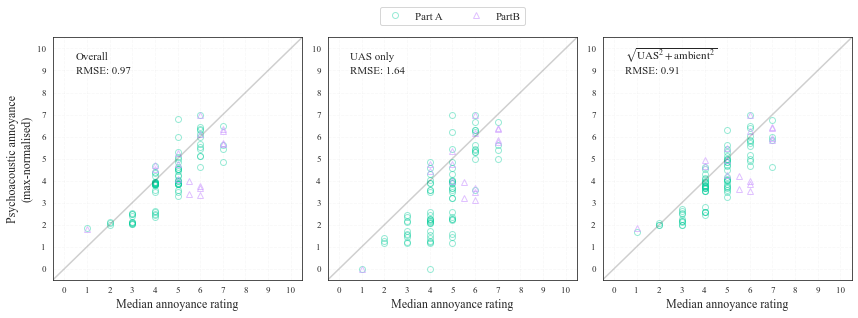

In [361]:
# plot results for Widmann model

# median
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMedPtAWidmann_1, paMedPtAUASWidmann_1, paMedPtAUASAmbWidmann_1]):
    
    datasetB = [paMedPtBWidmann_1, paMedPtBUASWidmann_1, paMedPtBUASAmbWidmann_1][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMedian'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[1],
                 alpha=0.4)
    
    axs[ii].plot(dataByStimTestB['AnnoyMedian'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[5],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Median annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMedian'], dataByStimTestB['AnnoyMedian']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "WidmannnPAmed_1.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "WidmannnPAmed_1.pdf"),
                format='pdf')

plt.show()


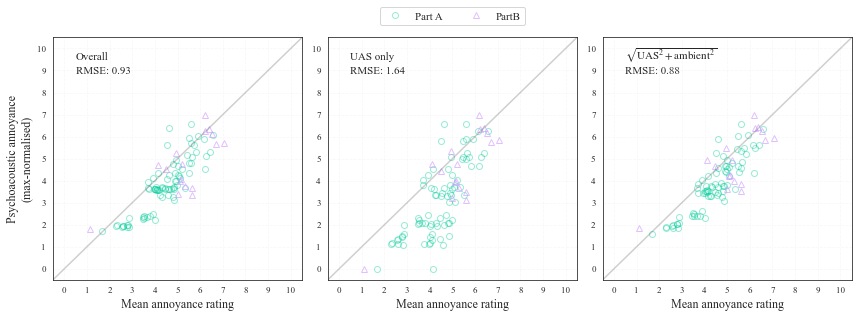

In [360]:
# plot results for Widmann model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMnPtAWidmann_1, paMnPtAUASWidmann_1, paMnPtAUASAmbWidmann_1]):
    
    datasetB = [paMedPtBWidmann_1, paMedPtBUASWidmann_1, paMedPtBUASAmbWidmann_1][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[1],
                 alpha=0.4)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[5],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "WidmannnPAmean_1.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "WidmannnPAmean_1.pdf"),
                format='pdf')

plt.show()


#### Widmann psychoacoustic annoyance with new input metrics

##### Part A

In [412]:
# calculate overall psychoacoustic annoyance
paPtAWidmann_2 = psychAnnoy(loudness=dataByStimTestA['LoudECMAHMSPowAvgBin'],
                            sharpness=dataByStimTestA['SharpAuresISO305ExMaxLR'],
                            roughness=dataByStimTestA['RoughFZ05ExMaxLR'],
                            fluctstr=dataByStimTestA['FluctOV05ExMaxLR'],
                            tonality=None,
                            impulsivity=None,
                            method='widmann')
paMedPtAWidmann_2 = paPtAWidmann_2/paPtAWidmann_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAWidmann_2 = paPtAWidmann_2/paPtAWidmann_2.max()*dataByStimTestA['AnnoyMean'].max()

In [413]:
# calculate UAS only psychoacoustic annoyance
paPtAUASWidmann_2 = psychAnnoy(loudness=dataByStimTestA['UASLoudECMAHMSPowAvgBin'],
                               sharpness=dataByStimTestA['UASSharpAuresISO305ExMaxLR'],
                               roughness=dataByStimTestA['UASRoughFZ05ExMaxLR'],
                               fluctstr=dataByStimTestA['UASFluctOV05ExMaxLR'],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtAUASWidmann_2.fillna(0, inplace=True)
paMedPtAUASWidmann_2 = paPtAUASWidmann_2/paPtAUASWidmann_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASWidmann_2 = paPtAUASWidmann_2/paPtAUASWidmann_2.max()*dataByStimTestA['AnnoyMean'].max()

In [414]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbWidmann_2 = np.sqrt(paPtAUASWidmann_2**2 + psychAnnoy(loudness=dataByStimTestA['AmbLoudECMAHMSPowAvgBin'],
                                                      sharpness=dataByStimTestA['AmbSharpAuresISO305ExMaxLR'],
                                                      roughness=dataByStimTestA['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestA['AmbFluctOV05ExMaxLR'],
                                                      tonality=None,
                                                      impulsivity=None,
                                                      method='widmann')**2)
paMedPtAUASAmbWidmann_2 = paPtAUASAmbWidmann_2/paPtAUASAmbWidmann_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASAmbWidmann_2 = paPtAUASAmbWidmann_2/paPtAUASAmbWidmann_2.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [415]:
# calculate overall psychoacoustic annoyance
paPtBWidmann_2 = psychAnnoy(loudness=dataByStimTestB['LoudECMAHMSPowAvgBin'],
                            sharpness=dataByStimTestB['SharpAuresISO305ExMaxLR'],
                            roughness=dataByStimTestB['RoughFZ05ExMaxLR'],
                            fluctstr=dataByStimTestB['FluctOV05ExMaxLR'],
                            tonality=None,
                            impulsivity=None,
                            method='widmann')
paMedPtBWidmann_2 = paPtBWidmann_2/paPtBWidmann_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBWidmann_2 = paPtBWidmann_2/paPtBWidmann_2.max()*dataByStimTestB['AnnoyMean'].max()

In [416]:
# calculate UAS only psychoacoustic annoyance
paPtBUASWidmann_2 = psychAnnoy(loudness=dataByStimTestB['UASLoudECMAHMSPowAvgBin'],
                               sharpness=dataByStimTestB['UASSharpAuresISO305ExMaxLR'],
                               roughness=dataByStimTestB['UASRoughFZ05ExMaxLR'],
                               fluctstr=dataByStimTestB['UASFluctOV05ExMaxLR'],
                               tonality=None,
                               impulsivity=None,
                               method='widmann')
paPtBUASWidmann_2.fillna(0, inplace=True)
paMedPtBUASWidmann_2 = paPtBUASWidmann_2/paPtBUASWidmann_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASWidmann_2 = paPtBUASWidmann_2/paPtBUASWidmann_2.max()*dataByStimTestB['AnnoyMean'].max()

In [417]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtBUASAmbWidmann_2 = np.sqrt(paPtBUASWidmann_2**2 + psychAnnoy(loudness=dataByStimTestB['AmbLoudECMAHMSPowAvgBin'],
                                                      sharpness=dataByStimTestB['AmbSharpAuresISO305ExMaxLR'],
                                                      roughness=dataByStimTestB['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestB['AmbFluctOV05ExMaxLR'],
                                                      tonality=None,
                                                      impulsivity=None,
                                                      method='widmann')**2)
paMedPtBUASAmbWidmann_2 = paPtBUASAmbWidmann_2/paPtBUASAmbWidmann_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASAmbWidmann_2 = paPtBUASAmbWidmann_2/paPtBUASAmbWidmann_2.max()*dataByStimTestB['AnnoyMean'].max()

##### Plot results

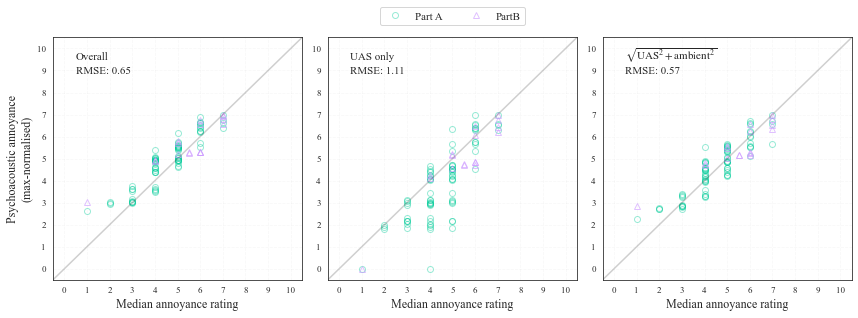

In [418]:
# plot results for Widmann model with new input metrics

# median
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMedPtAWidmann_2, paMedPtAUASWidmann_2, paMedPtAUASAmbWidmann_2]):
    
    datasetB = [paMedPtBWidmann_2, paMedPtBUASWidmann_2, paMedPtBUASAmbWidmann_2][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMedian'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[1],
                 alpha=0.4)
    
    axs[ii].plot(dataByStimTestB['AnnoyMedian'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[5],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Median annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMedian'], dataByStimTestB['AnnoyMedian']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


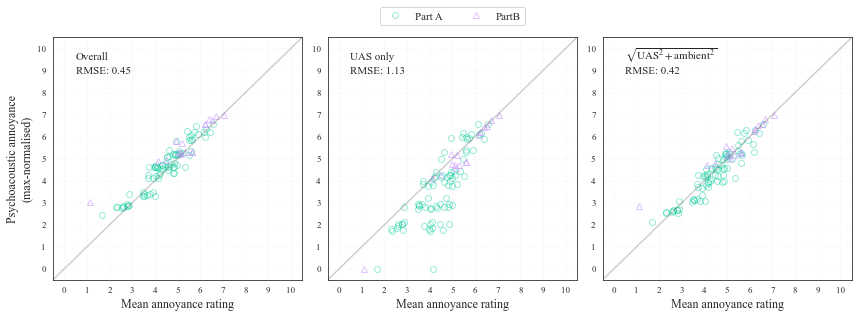

In [419]:
# plot results for Widmann model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMnPtAWidmann_2, paMnPtAUASWidmann_2, paMnPtAUASAmbWidmann_2]):
    
    datasetB = [paMedPtBWidmann_2, paMedPtBUASWidmann_2, paMedPtBUASAmbWidmann_2][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[1],
                 alpha=0.4)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[5],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


#### Di psychoacoustic annoyance

##### Part A

In [296]:
# calculate overall psychoacoustic annoyance
paPtADi_1 = psychAnnoy(loudness=dataByStimTestA['LoudISO105ExMaxLR'],
                       sharpness=dataByStimTestA['SharpVonBisISO105ExMaxLR'],
                       roughness=dataByStimTestA['RoughFZ05ExMaxLR'],
                       fluctstr=dataByStimTestA['FluctFZ05ExMaxLR'],
                       tonality=dataByStimTestA['TonalAu05ExMaxLR'],
                       impulsivity=None,
                       method='di')
paMedPtADi_1 = paPtADi_1/paPtADi_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtADi_1 = paPtADi_1/paPtADi_1.max()*dataByStimTestA['AnnoyMean'].max()

In [297]:
# calculate UAS only psychoacoustic annoyance
paPtAUASDi_1 = psychAnnoy(loudness=dataByStimTestA['UASLoudISO105ExMaxLR'],
                           sharpness=dataByStimTestA['UASSharpVonBisISO105ExMaxLR'],
                           roughness=dataByStimTestA['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestA['UASFluctFZ05ExMaxLR'],
                           tonality=dataByStimTestA['UASTonalAu05ExMaxLR'],
                           impulsivity=None,
                           method='di')
paPtAUASDi_1.fillna(0, inplace=True)
paMedPtAUASDi_1 = paPtAUASDi_1/paPtAUASDi_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASDi_1 = paPtAUASDi_1/paPtAUASDi_1.max()*dataByStimTestA['AnnoyMean'].max()

In [298]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbDi_1 = np.sqrt(paPtAUASDi_1**2 + psychAnnoy(loudness=dataByStimTestA['AmbLoudISO105ExMaxLR'],
                                                      sharpness=dataByStimTestA['AmbSharpVonBisISO105ExMaxLR'],
                                                      roughness=dataByStimTestA['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestA['AmbFluctFZ05ExMaxLR'],
                                                      tonality=dataByStimTestA['AmbTonalAu05ExMaxLR'],
                                                      impulsivity=None,
                                                      method='di')**2)
paMedPtAUASAmbDi_1 = paPtAUASAmbDi_1/paPtAUASAmbDi_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASAmbDi_1 = paPtAUASAmbDi_1/paPtAUASAmbDi_1.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [299]:
# calculate overall psychoacoustic annoyance
paPtBDi_1 = psychAnnoy(loudness=dataByStimTestB['LoudISO105ExMaxLR'],
                        sharpness=dataByStimTestB['SharpVonBisISO105ExMaxLR'],
                        roughness=dataByStimTestB['RoughFZ05ExMaxLR'],
                        fluctstr=dataByStimTestB['FluctFZ05ExMaxLR'],
                        tonality=dataByStimTestB['TonalAu05ExMaxLR'],
                        impulsivity=None,
                        method='di')
paMedPtBDi_1 = paPtBDi_1/paPtBDi_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBDi_1 = paPtBDi_1/paPtBDi_1.max()*dataByStimTestB['AnnoyMean'].max()

In [300]:
# calculate UAS only psychoacoustic annoyance
paPtBUASDi_1 = psychAnnoy(loudness=dataByStimTestB['UASLoudISO105ExMaxLR'],
                           sharpness=dataByStimTestB['UASSharpVonBisISO105ExMaxLR'],
                           roughness=dataByStimTestB['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestB['UASFluctFZ05ExMaxLR'],
                           tonality=dataByStimTestB['UASTonalAu05ExMaxLR'],
                           impulsivity=None,
                           method='di')
paPtBUASDi_1.fillna(0, inplace=True)
paMedPtBUASDi_1 = paPtBUASDi_1/paPtBUASDi_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASDi_1 = paPtBUASDi_1/paPtBUASDi_1.max()*dataByStimTestB['AnnoyMean'].max()

In [301]:
# calculate ratio between UAS and ambient psychoacoustic annoyance
paPtBUASAmbDi_1 = np.sqrt(paPtBUASDi_1**2 + psychAnnoy(loudness=dataByStimTestB['AmbLoudISO105ExMaxLR'],
                                                      sharpness=dataByStimTestB['AmbSharpVonBisISO105ExMaxLR'],
                                                      roughness=dataByStimTestB['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestB['AmbFluctFZ05ExMaxLR'],
                                                      tonality=dataByStimTestB['AmbTonalAu05ExMaxLR'],
                                                      impulsivity=None,
                                                      method='di')**2)
paMedPtBUASAmbDi_1 = paPtBUASAmbDi_1/paPtBUASAmbDi_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASAmbDi_1 = paPtBUASAmbDi_1/paPtBUASAmbDi_1.max()*dataByStimTestB['AnnoyMean'].max()

##### Plot results

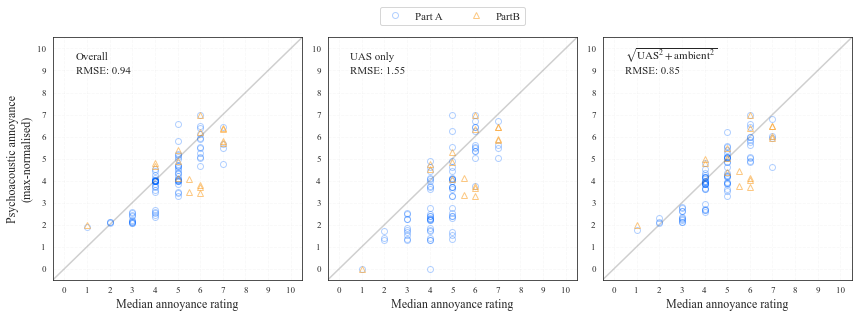

In [362]:
# plot results for Di model

# median
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMedPtADi_1, paMedPtAUASDi_1, paMedPtAUASAmbDi_1]):
    
    datasetB = [paMedPtBDi_1, paMedPtBUASDi_1, paMedPtBUASAmbDi_1][ii]

    axs[ii].plot(dataByStimTestA['AnnoyMedian'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[0],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMedian'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Median annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMedian'], dataByStimTestB['AnnoyMedian']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


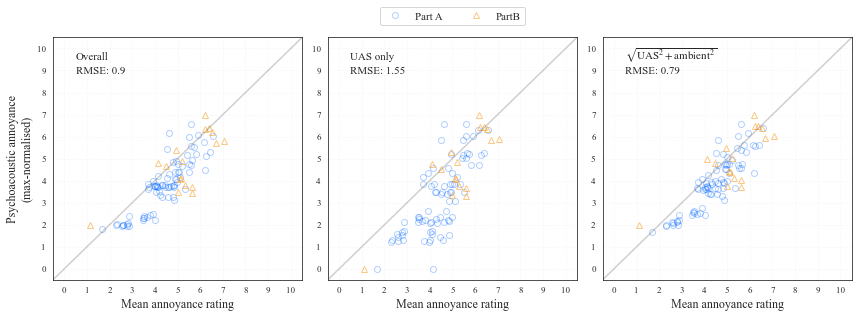

In [363]:
# plot results for Di model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMnPtADi_1, paMnPtAUASDi_1, paMnPtAUASAmbDi_1]):
    
    datasetB = [paMedPtBDi_1, paMedPtBUASDi_1, paMedPtBUASAmbDi_1][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[0],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


#### Di psychoacoustic annoyance with new input metrics

##### Part A

In [420]:
# calculate overall psychoacoustic annoyance
paPtADi_2 = psychAnnoy(loudness=dataByStimTestA['LoudECMAHMSPowAvgBin'],
                       sharpness=dataByStimTestA['SharpAuresISO305ExMaxLR'],
                       roughness=dataByStimTestA['RoughFZ05ExMaxLR'],
                       fluctstr=dataByStimTestA['FluctOV05ExMaxLR'],
                       tonality=dataByStimTestA['TonalInt05ExMaxLR'],
                       impulsivity=None,
                       method='di')
paMedPtADi_2 = paPtADi_2/paPtADi_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtADi_2 = paPtADi_2/paPtADi_2.max()*dataByStimTestA['AnnoyMean'].max()

In [421]:
# calculate UAS only psychoacoustic annoyance
paPtAUASDi_2 = psychAnnoy(loudness=dataByStimTestA['UASLoudECMAHMSPowAvgBin'],
                           sharpness=dataByStimTestA['UASSharpAuresISO305ExMaxLR'],
                           roughness=dataByStimTestA['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestA['UASFluctOV05ExMaxLR'],
                           tonality=dataByStimTestA['UASTonalInt05ExMaxLR'],
                           impulsivity=None,
                           method='di')
paPtAUASDi_2.fillna(0, inplace=True)
paMedPtAUASDi_2 = paPtAUASDi_2/paPtAUASDi_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASDi_2 = paPtAUASDi_2/paPtAUASDi_2.max()*dataByStimTestA['AnnoyMean'].max()

In [422]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbDi_2 = np.sqrt(paPtAUASDi_2**2 + psychAnnoy(loudness=dataByStimTestA['AmbLoudECMAHMSPowAvgBin'],
                                                      sharpness=dataByStimTestA['AmbSharpAuresISO305ExMaxLR'],
                                                      roughness=dataByStimTestA['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestA['AmbFluctOV05ExMaxLR'],
                                                      tonality=dataByStimTestA['AmbTonalInt05ExMaxLR'],
                                                      impulsivity=None,
                                                      method='di')**2)
paMedPtAUASAmbDi_2 = paPtAUASAmbDi_2/paPtAUASAmbDi_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASAmbDi_2 = paPtAUASAmbDi_2/paPtAUASAmbDi_2.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [423]:
# calculate overall psychoacoustic annoyance
paPtBDi_2 = psychAnnoy(loudness=dataByStimTestB['LoudECMAHMSPowAvgBin'],
                        sharpness=dataByStimTestB['SharpAuresISO305ExMaxLR'],
                        roughness=dataByStimTestB['RoughFZ05ExMaxLR'],
                        fluctstr=dataByStimTestB['FluctOV05ExMaxLR'],
                        tonality=dataByStimTestB['TonalInt05ExMaxLR'],
                        impulsivity=None,
                        method='di')
paMedPtBDi_2 = paPtBDi_2/paPtBDi_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBDi_2 = paPtBDi_2/paPtBDi_2.max()*dataByStimTestB['AnnoyMean'].max()

In [424]:
# calculate UAS only psychoacoustic annoyance
paPtBUASDi_2 = psychAnnoy(loudness=dataByStimTestB['UASLoudECMAHMSPowAvgBin'],
                           sharpness=dataByStimTestB['UASSharpAuresISO305ExMaxLR'],
                           roughness=dataByStimTestB['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestB['UASFluctOV05ExMaxLR'],
                           tonality=dataByStimTestB['UASTonalInt05ExMaxLR'],
                           impulsivity=None,
                           method='di')
paPtBUASDi_2.fillna(0, inplace=True)
paMedPtBUASDi_2 = paPtBUASDi_2/paPtBUASDi_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASDi_2 = paPtBUASDi_2/paPtBUASDi_2.max()*dataByStimTestB['AnnoyMean'].max()

In [425]:
# calculate ratio between UAS and ambient psychoacoustic annoyance
paPtBUASAmbDi_2 = np.sqrt(paPtBUASDi_2**2 + psychAnnoy(loudness=dataByStimTestB['AmbLoudECMAHMSPowAvgBin'],
                                                      sharpness=dataByStimTestB['AmbSharpAuresISO305ExMaxLR'],
                                                      roughness=dataByStimTestB['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestB['AmbFluctOV05ExMaxLR'],
                                                      tonality=dataByStimTestB['AmbTonalInt05ExMaxLR'],
                                                      impulsivity=None,
                                                      method='di')**2)
paMedPtBUASAmbDi_2 = paPtBUASAmbDi_2/paPtBUASAmbDi_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASAmbDi_2 = paPtBUASAmbDi_2/paPtBUASAmbDi_2.max()*dataByStimTestB['AnnoyMean'].max()

##### Plot results

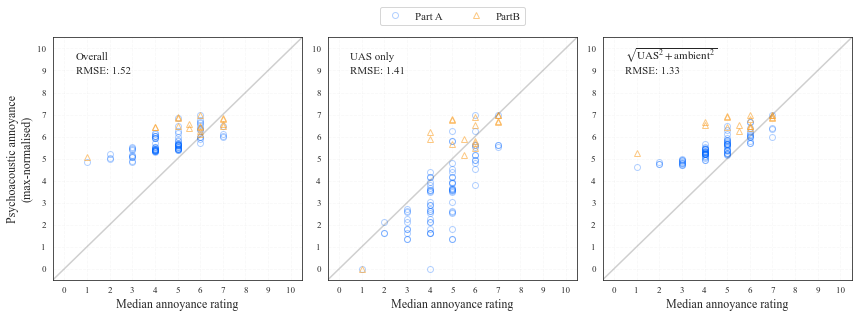

In [426]:
# plot results for Di model

# median
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMedPtADi_2, paMedPtAUASDi_2, paMedPtAUASAmbDi_2]):
    
    datasetB = [paMedPtBDi_2, paMedPtBUASDi_2, paMedPtBUASAmbDi_2][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMedian'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[0],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMedian'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Median annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMedian'], dataByStimTestB['AnnoyMedian']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


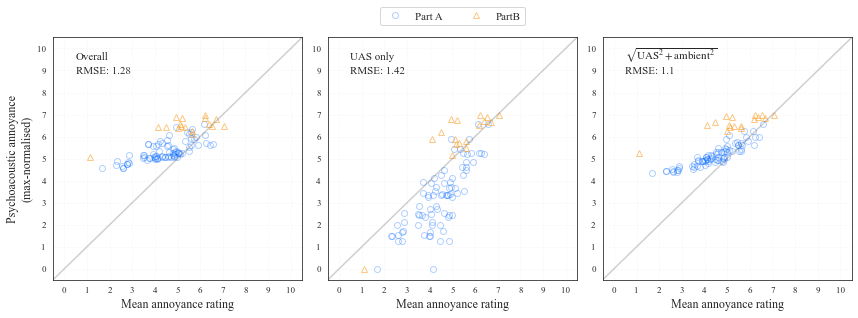

In [427]:
# plot results for Di model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMnPtADi_2, paMnPtAUASDi_2, paMnPtAUASAmbDi_2]):
    
    datasetB = [paMedPtBDi_2, paMedPtBUASDi_2, paMedPtBUASAmbDi_2][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[0],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


#### More psychoacoustic annoyance

##### Part A

In [335]:
# calculate overall psychoacoustic annoyance
paPtAMore_1 = psychAnnoy(loudness=dataByStimTestA['LoudISO105ExMaxLR'],
                           sharpness=dataByStimTestA['SharpVonBisISO105ExMaxLR'],
                           roughness=dataByStimTestA['RoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestA['FluctFZ05ExMaxLR'],
                           tonality=dataByStimTestA['TonalAu05ExMaxLR'],
                           impulsivity=None,
                           method='more')
paMedPtAMore_1 = paPtAMore_1/paPtAMore_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAMore_1 = paPtAMore_1/paPtAMore_1.max()*dataByStimTestA['AnnoyMean'].max()

In [305]:
# calculate UAS only psychoacoustic annoyance
paPtAUASMore_1 = psychAnnoy(loudness=dataByStimTestA['UASLoudISO105ExMaxLR'],
                           sharpness=dataByStimTestA['UASSharpVonBisISO105ExMaxLR'],
                           roughness=dataByStimTestA['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestA['UASFluctFZ05ExMaxLR'],
                           tonality=dataByStimTestA['UASTonalAu05ExMaxLR'],
                           impulsivity=None,
                           method='more')
paPtAUASMore_1.fillna(0, inplace=True)
paMedPtAUASMore_1 = paPtAUASMore_1/paPtAUASMore_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASMore_1 = paPtAUASMore_1/paPtAUASMore_1.max()*dataByStimTestA['AnnoyMean'].max()

In [306]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbMore_1 = np.sqrt(paPtAUASMore_1**2 + psychAnnoy(loudness=dataByStimTestA['AmbLoudISO105ExMaxLR'],
                                                      sharpness=dataByStimTestA['AmbSharpVonBisISO105ExMaxLR'],
                                                      roughness=dataByStimTestA['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestA['AmbFluctFZ05ExMaxLR'],
                                                      tonality=dataByStimTestA['AmbTonalAu05ExMaxLR'],
                                                      impulsivity=None,
                                                      method='more')**2)
paMedPtAUASAmbMore_1 = paPtAUASAmbMore_1/paPtAUASAmbMore_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASAmbMore_1 = paPtAUASAmbMore_1/paPtAUASAmbMore_1.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [307]:
# calculate overall psychoacoustic annoyance
paPtBMore_1 = psychAnnoy(loudness=dataByStimTestB['LoudISO105ExMaxLR'],
                        sharpness=dataByStimTestB['SharpVonBisISO105ExMaxLR'],
                        roughness=dataByStimTestB['RoughFZ05ExMaxLR'],
                        fluctstr=dataByStimTestB['FluctFZ05ExMaxLR'],
                        tonality=dataByStimTestB['TonalAu05ExMaxLR'],
                        impulsivity=None,
                        method='more')
paMedPtBMore_1 = paPtBMore_1/paPtBMore_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBMore_1 = paPtBMore_1/paPtBMore_1.max()*dataByStimTestB['AnnoyMean'].max()

In [308]:
# calculate UAS only psychoacoustic annoyance
paPtBUASMore_1 = psychAnnoy(loudness=dataByStimTestB['UASLoudISO105ExMaxLR'],
                           sharpness=dataByStimTestB['UASSharpVonBisISO105ExMaxLR'],
                           roughness=dataByStimTestB['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestB['UASFluctFZ05ExMaxLR'],
                           tonality=dataByStimTestB['UASTonalAu05ExMaxLR'],
                           impulsivity=None,
                           method='more')
paPtBUASMore_1.fillna(0, inplace=True)
paMedPtBUASMore_1 = paPtBUASMore_1/paPtBUASMore_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASMore_1 = paPtBUASMore_1/paPtBUASMore_1.max()*dataByStimTestB['AnnoyMean'].max()

In [309]:
# calculate ratio between UAS and ambient psychoacoustic annoyance
paPtBUASAmbMore_1 = np.sqrt(paPtBUASMore_1**2 + psychAnnoy(loudness=dataByStimTestB['AmbLoudISO105ExMaxLR'],
                                                          sharpness=dataByStimTestB['AmbSharpVonBisISO105ExMaxLR'],
                                                          roughness=dataByStimTestB['AmbRoughFZ05ExMaxLR'],
                                                          fluctstr=dataByStimTestB['AmbFluctFZ05ExMaxLR'],
                                                          tonality=dataByStimTestB['AmbTonalAu05ExMaxLR'],
                                                          impulsivity=None,
                                                          method='more')**2)
paMedPtBUASAmbMore_1 = paPtBUASAmbMore_1/paPtBUASAmbMore_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASAmbMore_1 = paPtBUASAmbMore_1/paPtBUASAmbMore_1.max()*dataByStimTestB['AnnoyMean'].max()

##### Plot results

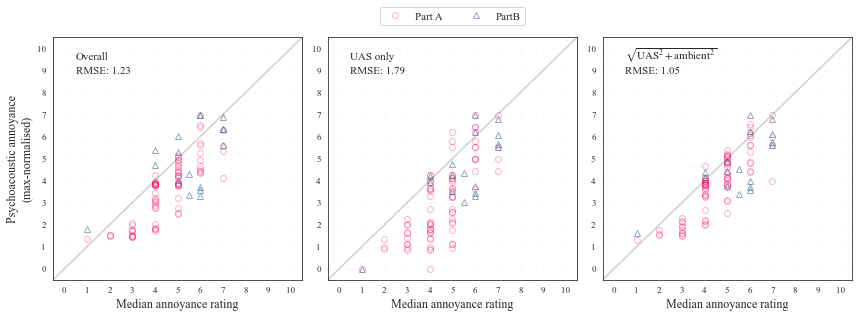

In [336]:
# plot results for More model

# median
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMedPtAMore_1, paMedPtAUASMore_1, paMedPtAUASAmbMore_1]):
    
    datasetB = [paMedPtBMore_1, paMedPtBUASMore_1, paMedPtBUASAmbMore_1][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMedian'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMedian'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[3],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Median annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMedian'], dataByStimTestB['AnnoyMedian']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


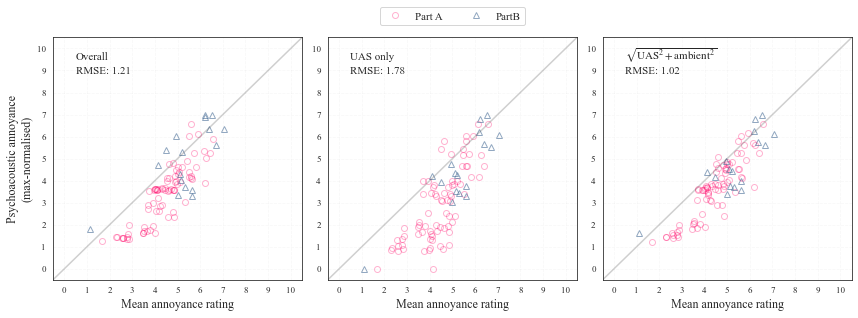

In [311]:
# plot results for More model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMnPtAMore_1, paMnPtAUASMore_1, paMnPtAUASAmbMore_1]):
    
    datasetB = [paMedPtBMore_1, paMedPtBUASMore_1, paMedPtBUASAmbMore_1][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[3],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


#### More psychoacoustic annoyance with new input metrics

##### Part A

In [436]:
# calculate overall psychoacoustic annoyance
paPtAMore_2 = psychAnnoy(loudness=dataByStimTestA['LoudECMAHMSPowAvgBin'],
                           sharpness=dataByStimTestA['SharpAuresISO305ExMaxLR'],
                           roughness=dataByStimTestA['RoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestA['FluctOV05ExMaxLR'],
                           tonality=dataByStimTestA['TonalInt05ExMaxLR'],
                           impulsivity=None,
                           method='more')
paMedPtAMore_2 = paPtAMore_2/paPtAMore_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAMore_2 = paPtAMore_2/paPtAMore_2.max()*dataByStimTestA['AnnoyMean'].max()

In [437]:
# calculate UAS only psychoacoustic annoyance
paPtAUASMore_2 = psychAnnoy(loudness=dataByStimTestA['UASLoudECMAHMSPowAvgBin'],
                           sharpness=dataByStimTestA['UASSharpAuresISO305ExMaxLR'],
                           roughness=dataByStimTestA['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestA['UASFluctOV05ExMaxLR'],
                           tonality=dataByStimTestA['UASTonalInt05ExMaxLR'],
                           impulsivity=None,
                           method='more')
paPtAUASMore_2.fillna(0, inplace=True)
paMedPtAUASMore_2 = paPtAUASMore_2/paPtAUASMore_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASMore_2 = paPtAUASMore_2/paPtAUASMore_2.max()*dataByStimTestA['AnnoyMean'].max()

In [438]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbMore_2 = np.sqrt(paPtAUASMore_2**2 + psychAnnoy(loudness=dataByStimTestA['AmbLoudECMAHMSPowAvgBin'],
                                                      sharpness=dataByStimTestA['AmbSharpAuresISO305ExMaxLR'],
                                                      roughness=dataByStimTestA['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestA['AmbFluctOV05ExMaxLR'],
                                                      tonality=dataByStimTestA['AmbTonalInt05ExMaxLR'],
                                                      impulsivity=None,
                                                      method='more')**2)
paMedPtAUASAmbMore_2 = paPtAUASAmbMore_2/paPtAUASAmbMore_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASAmbMore_2 = paPtAUASAmbMore_2/paPtAUASAmbMore_2.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [439]:
# calculate overall psychoacoustic annoyance
paPtBMore_2 = psychAnnoy(loudness=dataByStimTestB['LoudECMAHMSPowAvgBin'],
                        sharpness=dataByStimTestB['SharpAuresISO305ExMaxLR'],
                        roughness=dataByStimTestB['RoughFZ05ExMaxLR'],
                        fluctstr=dataByStimTestB['FluctOV05ExMaxLR'],
                        tonality=dataByStimTestB['TonalInt05ExMaxLR'],
                        impulsivity=None,
                        method='more')
paMedPtBMore_2 = paPtBMore_2/paPtBMore_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBMore_2 = paPtBMore_2/paPtBMore_2.max()*dataByStimTestB['AnnoyMean'].max()

In [440]:
# calculate UAS only psychoacoustic annoyance
paPtBUASMore_2 = psychAnnoy(loudness=dataByStimTestB['UASLoudECMAHMSPowAvgBin'],
                           sharpness=dataByStimTestB['UASSharpAuresISO305ExMaxLR'],
                           roughness=dataByStimTestB['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestB['UASFluctOV05ExMaxLR'],
                           tonality=dataByStimTestB['UASTonalInt05ExMaxLR'],
                           impulsivity=None,
                           method='more')
paPtBUASMore_2.fillna(0, inplace=True)
paMedPtBUASMore_2 = paPtBUASMore_2/paPtBUASMore_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASMore_2 = paPtBUASMore_2/paPtBUASMore_2.max()*dataByStimTestB['AnnoyMean'].max()

In [441]:
# calculate ratio between UAS and ambient psychoacoustic annoyance
paPtBUASAmbMore_2 = np.sqrt(paPtBUASMore_2**2 + psychAnnoy(loudness=dataByStimTestB['AmbLoudECMAHMSPowAvgBin'],
                                                          sharpness=dataByStimTestB['AmbSharpAuresISO305ExMaxLR'],
                                                          roughness=dataByStimTestB['AmbRoughFZ05ExMaxLR'],
                                                          fluctstr=dataByStimTestB['AmbFluctOV05ExMaxLR'],
                                                          tonality=dataByStimTestB['AmbTonalInt05ExMaxLR'],
                                                          impulsivity=None,
                                                          method='more')**2)
paMedPtBUASAmbMore_2 = paPtBUASAmbMore_2/paPtBUASAmbMore_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASAmbMore_2 = paPtBUASAmbMore_2/paPtBUASAmbMore_2.max()*dataByStimTestB['AnnoyMean'].max()

##### Plot results

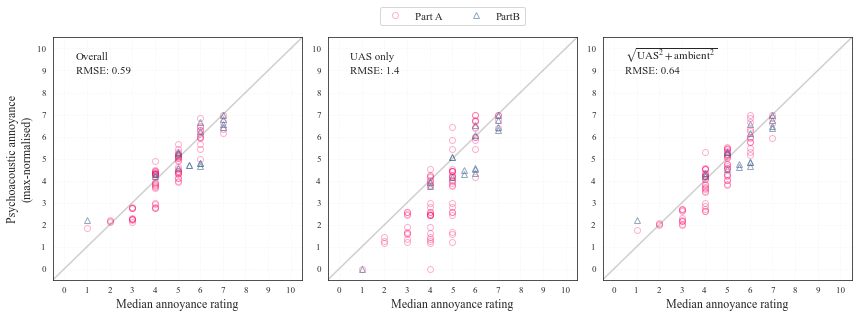

In [442]:
# plot results for More model

# median
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMedPtAMore_2, paMedPtAUASMore_2, paMedPtAUASAmbMore_2]):
    
    datasetB = [paMedPtBMore_2, paMedPtBUASMore_2, paMedPtBUASAmbMore_2][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMedian'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMedian'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[3],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Median annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMedian'], dataByStimTestB['AnnoyMedian']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


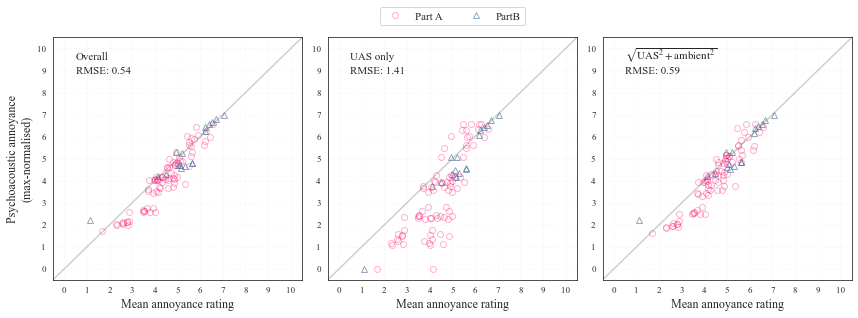

In [443]:
# plot results for More model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMnPtAMore_2, paMnPtAUASMore_2, paMnPtAUASAmbMore_2]):
    
    datasetB = [paMedPtBMore_2, paMedPtBUASMore_2, paMedPtBUASAmbMore_2][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[3],
                 alpha=0.6)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


#### Torija psychoacoustic annoyance

##### Part A

In [333]:
# calculate overall psychoacoustic annoyance
paPtATorija_1 = psychAnnoy(loudness=dataByStimTestA['LoudISO105ExMaxLR'],
                           sharpness=dataByStimTestA['SharpDIN4569205ExMaxLR'],
                           roughness=dataByStimTestA['RoughECMAHMS05ExBin'],
                           fluctstr=dataByStimTestA['FluctHMS05ExBin'],
                           tonality=dataByStimTestA['TonalAu05ExMaxLR'],
                           impulsivity=dataByStimTestA['ImpulsHMS05ExMaxLR'],
                           method='torija')
paMedPtATorija_1 = paPtATorija_1/paPtATorija_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtATorija_1 = paPtATorija_1/paPtATorija_1.max()*dataByStimTestA['AnnoyMean'].max()

In [326]:
# calculate UAS only psychoacoustic annoyance
paPtAUASTorija_1 = psychAnnoy(loudness=dataByStimTestA['UASLoudISO105ExMaxLR'],
                           sharpness=dataByStimTestA['UASSharpDIN4569205ExMaxLR'],
                           roughness=dataByStimTestA['UASRoughECMAHMS05ExBin'],
                           fluctstr=dataByStimTestA['UASFluctHMS05ExBin'],
                           tonality=dataByStimTestA['UASTonalAu05ExMaxLR'],
                           impulsivity=dataByStimTestA['UASImpulsHMS05ExMaxLR'],
                           method='torija')
paPtAUASTorija_1.fillna(0, inplace=True)
paMedPtAUASTorija_1 = paPtAUASTorija_1/paPtAUASTorija_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASTorija_1 = paPtAUASTorija_1/paPtAUASTorija_1.max()*dataByStimTestA['AnnoyMean'].max()

In [327]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbTorija_1 = np.sqrt(paPtAUASTorija_1**2 + psychAnnoy(loudness=dataByStimTestA['AmbLoudISO105ExMaxLR'],
                                                      sharpness=dataByStimTestA['AmbSharpDIN4569205ExMaxLR'],
                                                      roughness=dataByStimTestA['AmbRoughECMAHMS05ExBin'],
                                                      fluctstr=dataByStimTestA['AmbFluctHMS05ExBin'],
                                                      tonality=dataByStimTestA['AmbTonalAu05ExMaxLR'],
                                                      impulsivity=dataByStimTestA['AmbImpulsHMS05ExMaxLR'],
                                                      method='torija')**2)
paMedPtAUASAmbTorija_1 = paPtAUASAmbTorija_1/paPtAUASAmbTorija_1.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASAmbTorija_1 = paPtAUASAmbTorija_1/paPtAUASAmbTorija_1.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [328]:
# calculate overall psychoacoustic annoyance
paPtBTorija_1 = psychAnnoy(loudness=dataByStimTestB['LoudISO105ExMaxLR'],
                        sharpness=dataByStimTestB['SharpDIN4569205ExMaxLR'],
                        roughness=dataByStimTestB['RoughECMAHMS05ExBin'],
                        fluctstr=dataByStimTestB['FluctHMS05ExBin'],
                        tonality=dataByStimTestB['TonalAu05ExMaxLR'],
                        impulsivity=dataByStimTestB['ImpulsHMS05ExMaxLR'],
                        method='torija')
paMedPtBTorija_1 = paPtBTorija_1/paPtBTorija_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBTorija_1 = paPtBTorija_1/paPtBTorija_1.max()*dataByStimTestB['AnnoyMean'].max()

In [329]:
# calculate UAS only psychoacoustic annoyance
paPtBUASTorija_1 = psychAnnoy(loudness=dataByStimTestB['UASLoudISO105ExMaxLR'],
                           sharpness=dataByStimTestB['UASSharpDIN4569205ExMaxLR'],
                           roughness=dataByStimTestB['UASRoughECMAHMS05ExBin'],
                           fluctstr=dataByStimTestB['UASFluctHMS05ExBin'],
                           tonality=dataByStimTestB['UASTonalAu05ExMaxLR'],
                           impulsivity=dataByStimTestB['UASImpulsHMS05ExMaxLR'],
                           method='torija')
paPtBUASTorija_1.fillna(0, inplace=True)
paMedPtBUASTorija_1 = paPtBUASTorija_1/paPtBUASTorija_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASTorija_1 = paPtBUASTorija_1/paPtBUASTorija_1.max()*dataByStimTestB['AnnoyMean'].max()

In [330]:
# calculate ratio between UAS and ambient psychoacoustic annoyance
paPtBUASAmbTorija_1 = np.sqrt(paPtBUASTorija_1**2 + psychAnnoy(loudness=dataByStimTestB['AmbLoudISO105ExMaxLR'],
                                                          sharpness=dataByStimTestB['AmbSharpDIN4569205ExMaxLR'],
                                                          roughness=dataByStimTestB['AmbRoughECMAHMS05ExBin'],
                                                          fluctstr=dataByStimTestB['AmbFluctHMS05ExBin'],
                                                          tonality=dataByStimTestB['AmbTonalAu05ExMaxLR'],
                                                          impulsivity=dataByStimTestB['AmbImpulsHMS05ExMaxLR'],
                                                          method='torija')**2)
paMedPtBUASAmbTorija_1 = paPtBUASAmbTorija_1/paPtBUASAmbTorija_1.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASAmbTorija_1 = paPtBUASAmbTorija_1/paPtBUASAmbTorija_1.max()*dataByStimTestB['AnnoyMean'].max()

##### Plot results

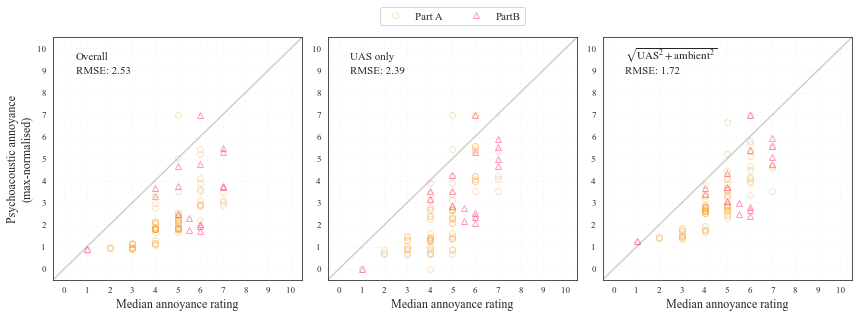

In [342]:
# plot results for Torija model

# median
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMedPtATorija_1, paMedPtAUASTorija_1, paMedPtAUASAmbTorija_1]):
    
    datasetB = [paMedPtBTorija_1, paMedPtBUASTorija_1, paMedPtBUASAmbTorija_1][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMedian'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMedian'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.4)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Median annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMedian'], dataByStimTestB['AnnoyMedian']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


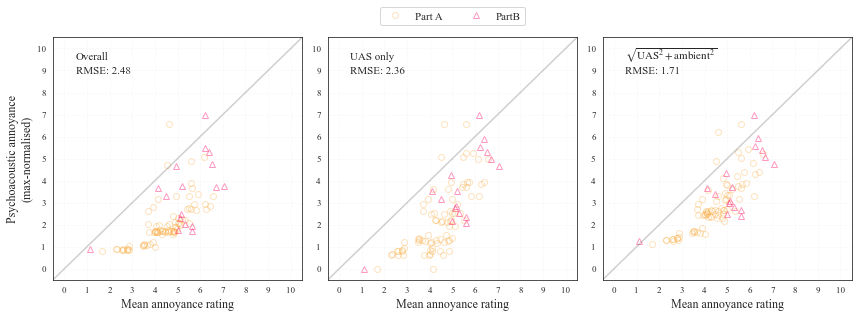

In [343]:
# plot results for Torija model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMnPtATorija_1, paMnPtAUASTorija_1, paMnPtAUASAmbTorija_1]):
    
    datasetB = [paMedPtBTorija_1, paMedPtBUASTorija_1, paMedPtBUASAmbTorija_1][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.4)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


#### Torija psychoacoustic annoyance with new input metrics

##### Part A

In [404]:
# calculate overall psychoacoustic annoyance
paPtATorija_2 = psychAnnoy(loudness=dataByStimTestA['LoudECMAHMSPowAvgBin'],
                           sharpness=dataByStimTestA['SharpAuresISO305ExMaxLR'],
                           roughness=dataByStimTestA['RoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestA['FluctOV05ExMaxLR'],
                           tonality=dataByStimTestA['TonalInt05ExMaxLR'],
                           impulsivity=dataByStimTestA['ImpulsHMS05ExMaxLR'],
                           method='torija')
paMedPtATorija_2 = paPtATorija_2/paPtATorija_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtATorija_2 = paPtATorija_2/paPtATorija_2.max()*dataByStimTestA['AnnoyMean'].max()

In [405]:
# calculate UAS only psychoacoustic annoyance
paPtAUASTorija_2= psychAnnoy(loudness=dataByStimTestA['UASLoudECMAHMSPowAvgBin'],
                           sharpness=dataByStimTestA['UASSharpAuresISO305ExMaxLR'],
                           roughness=dataByStimTestA['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestA['UASFluctOV05ExMaxLR'],
                           tonality=dataByStimTestA['UASTonalInt05ExMaxLR'],
                           impulsivity=dataByStimTestA['UASImpulsHMS05ExMaxLR'],
                           method='torija')
paPtAUASTorija_2.fillna(0, inplace=True)
paMedPtAUASTorija_2 = paPtAUASTorija_2/paPtAUASTorija_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASTorija_2 = paPtAUASTorija_2/paPtAUASTorija_2.max()*dataByStimTestA['AnnoyMean'].max()

In [406]:
# calculate combination of UAS and ambient psychoacoustic annoyance
paPtAUASAmbTorija_2 = np.sqrt(paPtAUASTorija_2**2 + psychAnnoy(loudness=dataByStimTestA['AmbLoudECMAHMSPowAvgBin'],
                                                      sharpness=dataByStimTestA['AmbSharpAuresISO305ExMaxLR'],
                                                      roughness=dataByStimTestA['AmbRoughFZ05ExMaxLR'],
                                                      fluctstr=dataByStimTestA['AmbFluctOV05ExMaxLR'],
                                                      tonality=dataByStimTestA['AmbTonalInt05ExMaxLR'],
                                                      impulsivity=dataByStimTestA['AmbImpulsHMS05ExMaxLR'],
                                                      method='torija')**2)
paMedPtAUASAmbTorija_2 = paPtAUASAmbTorija_2/paPtAUASAmbTorija_2.max()*dataByStimTestA['AnnoyMedian'].max()
paMnPtAUASAmbTorija_2 = paPtAUASAmbTorija_2/paPtAUASAmbTorija_2.max()*dataByStimTestA['AnnoyMean'].max()

##### Part B

In [407]:
# calculate overall psychoacoustic annoyance
paPtBTorija_2 = psychAnnoy(loudness=dataByStimTestB['LoudECMAHMSPowAvgBin'],
                        sharpness=dataByStimTestB['SharpAuresISO305ExMaxLR'],
                        roughness=dataByStimTestB['RoughFZ05ExMaxLR'],
                        fluctstr=dataByStimTestB['FluctOV05ExMaxLR'],
                        tonality=dataByStimTestB['TonalInt05ExMaxLR'],
                        impulsivity=dataByStimTestB['ImpulsHMS05ExMaxLR'],
                        method='torija')
paMedPtBTorija_2 = paPtBTorija_2/paPtBTorija_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBTorija_2 = paPtBTorija_2/paPtBTorija_2.max()*dataByStimTestB['AnnoyMean'].max()

In [408]:
# calculate UAS only psychoacoustic annoyance
paPtBUASTorija_2 = psychAnnoy(loudness=dataByStimTestB['UASLoudECMAHMSPowAvgBin'],
                           sharpness=dataByStimTestB['UASSharpAuresISO305ExMaxLR'],
                           roughness=dataByStimTestB['UASRoughFZ05ExMaxLR'],
                           fluctstr=dataByStimTestB['UASFluctOV05ExMaxLR'],
                           tonality=dataByStimTestB['UASTonalInt05ExMaxLR'],
                           impulsivity=dataByStimTestB['UASImpulsHMS05ExMaxLR'],
                           method='torija')
paPtBUASTorija_2.fillna(0, inplace=True)
paMedPtBUASTorija_2 = paPtBUASTorija_2/paPtBUASTorija_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASTorija_2 = paPtBUASTorija_2/paPtBUASTorija_2.max()*dataByStimTestB['AnnoyMean'].max()

In [409]:
# calculate ratio between UAS and ambient psychoacoustic annoyance
paPtBUASAmbTorija_2 = np.sqrt(paPtBUASTorija_2**2 + psychAnnoy(loudness=dataByStimTestB['AmbLoudECMAHMSPowAvgBin'],
                                                          sharpness=dataByStimTestB['AmbSharpAuresISO305ExMaxLR'],
                                                          roughness=dataByStimTestB['AmbRoughFZ05ExMaxLR'],
                                                          fluctstr=dataByStimTestB['AmbFluctOV05ExMaxLR'],
                                                          tonality=dataByStimTestB['AmbTonalInt05ExMaxLR'],
                                                          impulsivity=dataByStimTestB['AmbImpulsHMS05ExMaxLR'],
                                                          method='torija')**2)
paMedPtBUASAmbTorija_2 = paPtBUASAmbTorija_2/paPtBUASAmbTorija_2.max()*dataByStimTestB['AnnoyMedian'].max()
paMnPtBUASAmbTorija_2 = paPtBUASAmbTorija_2/paPtBUASAmbTorija_2.max()*dataByStimTestB['AnnoyMean'].max()

##### Plot results

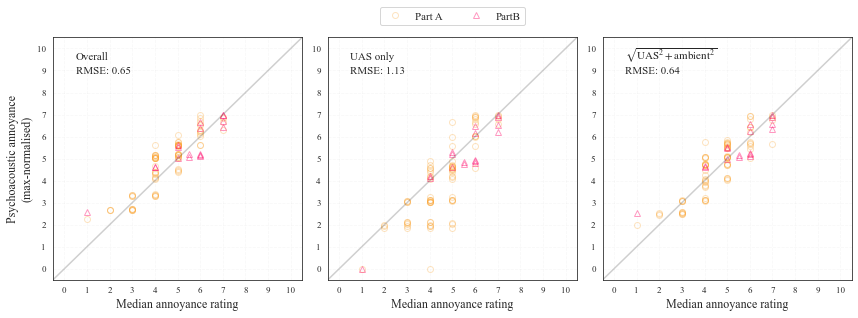

In [410]:
# plot results for Torija model

# median
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMedPtATorija_2, paMedPtAUASTorija_2, paMedPtAUASAmbTorija_2]):
    
    datasetB = [paMedPtBTorija_2, paMedPtBUASTorija_2, paMedPtBUASAmbTorija_2][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMedian'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMedian'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.4)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Median annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMedian'], dataByStimTestB['AnnoyMedian']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


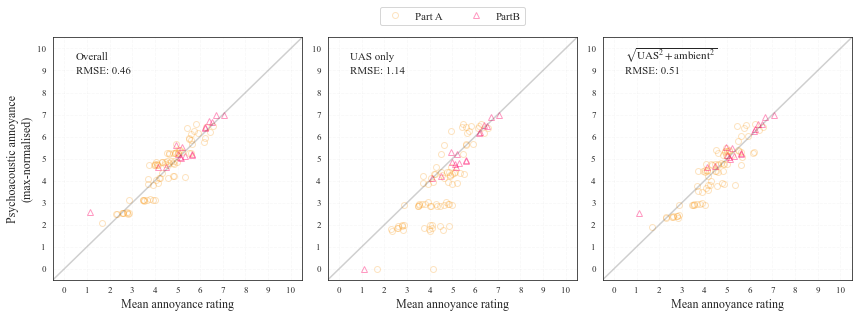

In [411]:
# plot results for Torija model

# mean
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4.5))

for ii, datasetA in enumerate([paMnPtATorija_2, paMnPtAUASTorija_2, paMnPtAUASAmbTorija_2]):
    
    datasetB = [paMedPtBTorija_2, paMedPtBUASTorija_2, paMedPtBUASAmbTorija_2][ii]
    
    axs[ii].plot(dataByStimTestA['AnnoyMean'], datasetA, linestyle='None',
                 marker='o', markerfacecolor='None', markeredgecolor=mycolours[4],
                 alpha=0.3)
    
    axs[ii].plot(dataByStimTestB['AnnoyMean'], datasetB, linestyle='None',
                 marker='^', markerfacecolor='None', markeredgecolor=mycolours[2],
                 alpha=0.4)

    axs[ii].set(xticks=range(0, 11), xlim=[-0.5, 10.5],
                yticks=range(0, 11), ylim=[-0.5, 10.5],
                xlabel="Mean annoyance rating")

    axs[ii].plot(np.arange(-1, 12), np.arange(-1, 12), color=[0.25, 0.25, 0.25], alpha=0.25)
    
    axs[ii].grid(alpha=0.15, linestyle='--')

    axs[ii].text(0.5, 9.5, ["Overall", "UAS only", "$\\sqrt{\\text{UAS}^2 + \\text{ambient}^2}$"][ii], fontsize=11)

    RMSE =  np.sqrt(np.square(pd.concat([datasetA, datasetB])
                              - pd.concat([dataByStimTestA['AnnoyMean'], dataByStimTestB['AnnoyMean']])).mean())

    axs[ii].text(0.5, 8.85, "RMSE: " + roundTrad(RMSE, 2).astype(str), fontsize=11)

    if ii == 0:
        axs[ii].set(ylabel="Psychoacoustic annoyance" + "\n"  +  "(max-normalised)")


    if ii == 1:
        axs[ii].legend(labels=['Part A', 'PartB'], bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=2, fontsize=11)

plt.show()


### Time-dependent

#### Loudness

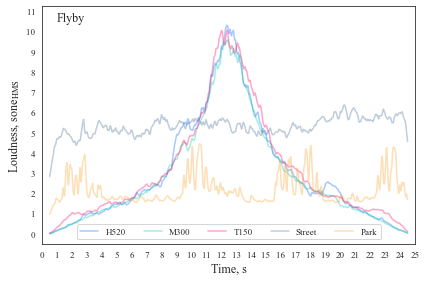

In [26]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet1'].iloc[13, 1:]
    # left channel
    specLoudnessHMSL = pd.DataFrame(workbookdata['Sheet1'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet1'].iloc[13, 1:],
                                    index=workbookdata['Sheet1'].iloc[14:, 0])
    # # right channel
    specLoudnessHMSR = pd.DataFrame(workbookdata['Sheet2'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet2'].iloc[13, 1:],
                                    index=workbookdata['Sheet2'].iloc[14:, 0])
    # # binaural specific loudness (ECMA-418-2:2022 Equation 118)
    specLoudnessHMSBin = ((specLoudnessHMSL**2
                           + specLoudnessHMSR**2)/2).pow(1/2)
    # # binaural time-dependent loudness (ECMA-418-2:2022 Equation 116)
    loudnessHMSTimeVar = specLoudnessHMSBin.sum(axis=0)*0.5

    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], loudnessHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=range(0, 12), xlim=[0, 25], ylim=[-0.5, 11.25],
       xlabel="Time, s", ylabel=r"Loudness, sone$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=10.5, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtALoudtDepFlyby.svg"), format='svg')
plt.show()

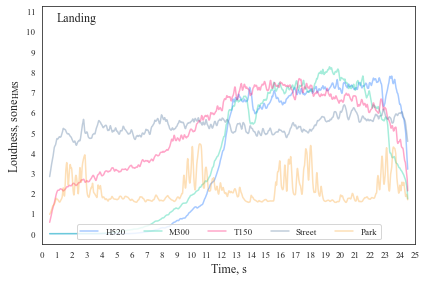

In [27]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet1'].iloc[13, 1:]
    # left channel
    specLoudnessHMSL = pd.DataFrame(workbookdata['Sheet1'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet1'].iloc[13, 1:],
                                    index=workbookdata['Sheet1'].iloc[14:, 0])
    # # right channel
    specLoudnessHMSR = pd.DataFrame(workbookdata['Sheet2'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet2'].iloc[13, 1:],
                                    index=workbookdata['Sheet2'].iloc[14:, 0])
    # # binaural specific loudness (ECMA-418-2:2022 Equation 118)
    specLoudnessHMSBin = ((specLoudnessHMSL**2
                           + specLoudnessHMSR**2)/2).pow(1/2)
    # # binaural time-dependent loudness (ECMA-418-2:2022 Equation 116)
    loudnessHMSTimeVar = specLoudnessHMSBin.sum(axis=0)*0.5

    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], loudnessHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=range(0, 12), xlim=[0, 25], ylim=[-0.5, 11.25],
       xlabel="Time, s", ylabel=r"Loudness, sone$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=10.5, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtALoudtDepLanding.svg"), format='svg')
plt.show()

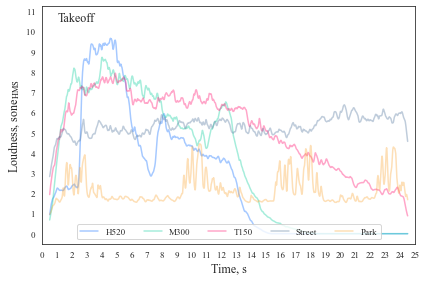

In [28]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet1'].iloc[13, 1:]
    # left channel
    specLoudnessHMSL = pd.DataFrame(workbookdata['Sheet1'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet1'].iloc[13, 1:],
                                    index=workbookdata['Sheet1'].iloc[14:, 0])
    # # right channel
    specLoudnessHMSR = pd.DataFrame(workbookdata['Sheet2'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet2'].iloc[13, 1:],
                                    index=workbookdata['Sheet2'].iloc[14:, 0])
    # # binaural specific loudness (ECMA-418-2:2022 Equation 118)
    specLoudnessHMSBin = ((specLoudnessHMSL**2
                           + specLoudnessHMSR**2)/2).pow(1/2)
    # # binaural time-dependent loudness (ECMA-418-2:2022 Equation 116)
    loudnessHMSTimeVar = specLoudnessHMSBin.sum(axis=0)*0.5

    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], loudnessHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=range(0, 12), xlim=[0, 25], ylim=[-0.5, 11.25],
       xlabel="Time, s", ylabel=r"Loudness, sone$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=10.5, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtALoudtDepTakeoff.svg"), format='svg')
plt.show()

#### Sharpness

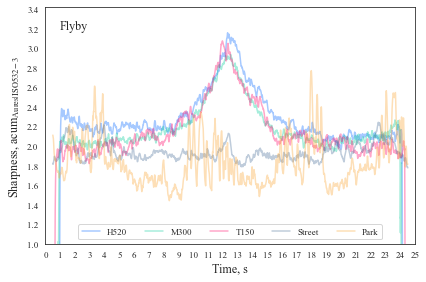

In [29]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet10'].iloc[13:, 0]
    sharpAISO3TimeVar2 = pd.DataFrame(workbookdata['Sheet10'].iloc[13:, 1:3].values,
                                     columns=workbookdata['Sheet10'].iloc[12, 1:3],
                                     index=workbookdata['Sheet10'].iloc[13:, 0])

    whichLR = np.argmax(sharpAISO3TimeVar2.mean(axis=0))
    sharpAISO3TimeVar = sharpAISO3TimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], sharpAISO3TimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(1, 4, 0.2), xlim=[0, 25], ylim=[1, 3.425],
       xlabel="Time, s", ylabel=r"Sharpness, acum$_\text{Aures|ISO532-3}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=3.2, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtASharptDepFlyby.svg"), format='svg')
plt.show()

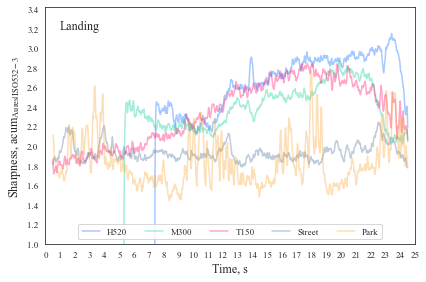

In [30]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet10'].iloc[13:, 0]
    sharpAISO3TimeVar2 = pd.DataFrame(workbookdata['Sheet10'].iloc[13:, 1:3].values,
                                     columns=workbookdata['Sheet10'].iloc[12, 1:3],
                                     index=workbookdata['Sheet10'].iloc[13:, 0])

    whichLR = np.argmax(sharpAISO3TimeVar2.mean(axis=0))
    sharpAISO3TimeVar = sharpAISO3TimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], sharpAISO3TimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(1, 4, 0.2), xlim=[0, 25], ylim=[1, 3.425],
       xlabel="Time, s", ylabel=r"Sharpness, acum$_\text{Aures|ISO532-3}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=1, y=3.2, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtASharptDepLanding.svg"), format='svg')
plt.show()

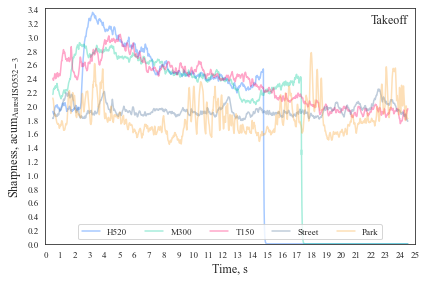

In [48]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet10'].iloc[13:, 0]
    sharpAISO3TimeVar2 = pd.DataFrame(workbookdata['Sheet10'].iloc[13:, 1:3].values,
                                     columns=workbookdata['Sheet10'].iloc[12, 1:3],
                                     index=workbookdata['Sheet10'].iloc[13:, 0])

    whichLR = np.argmax(sharpAISO3TimeVar2.mean(axis=0))
    sharpAISO3TimeVar = sharpAISO3TimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], sharpAISO3TimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 4, 0.2), xlim=[0, 25], ylim=[0, 3.425],
       xlabel="Time, s", ylabel=r"Sharpness, acum$_\text{Aures|ISO532-3}$")
ax.legend(labels=labels, ncol=len(labels), loc='lower center')
ax.text(x=22, y=3.2, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtASharptDepTakeoff.svg"), format='svg')
plt.show()

#### Tonality

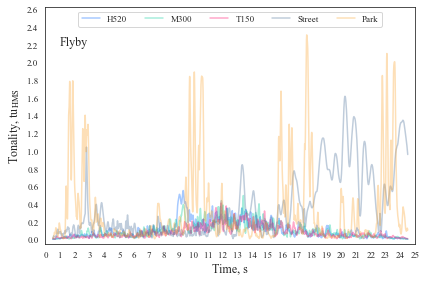

In [32]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet3'].iloc[13, 1:]
    # left channel
    specTonalityHMSL = pd.DataFrame(workbookdata['Sheet3'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet3'].iloc[13, 1:],
                                    index=workbookdata['Sheet3'].iloc[14:, 0])
    # right channel
    specTonalityHMSR = pd.DataFrame(workbookdata['Sheet4'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet4'].iloc[13, 1:],
                                    index=workbookdata['Sheet4'].iloc[14:, 0])
    # 2-channel time-varing tonality (max, not integration)
    tonalityHMSTimeVar2 = pd.concat([specTonalityHMSL.max(axis=0),
                                     specTonalityHMSR.max(axis=0)],
                                     axis=1)
    whichLR = np.argmax(tonalityHMSTimeVar2.mean(axis=0))
    tonalityHMSTimeVar = tonalityHMSTimeVar2.iloc[:, whichLR] 
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], tonalityHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 3, 0.2), xlim=[0, 25], ylim=[-0.05, 2.625],
       xlabel="Time, s", ylabel=r"Tonality, tu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=2.2, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtATonaltDepFlyby.svg"), format='svg')
plt.show()

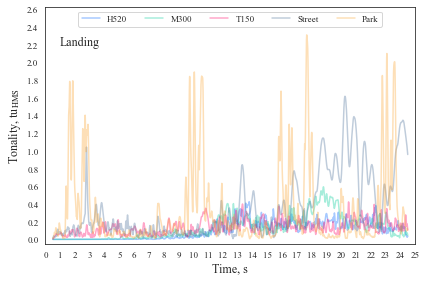

In [33]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet3'].iloc[13, 1:]
    # left channel
    specTonalityHMSL = pd.DataFrame(workbookdata['Sheet3'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet3'].iloc[13, 1:],
                                    index=workbookdata['Sheet3'].iloc[14:, 0])
    # right channel
    specTonalityHMSR = pd.DataFrame(workbookdata['Sheet4'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet4'].iloc[13, 1:],
                                    index=workbookdata['Sheet4'].iloc[14:, 0])
    # 2-channel time-varing tonality (max, not integration)
    tonalityHMSTimeVar2 = pd.concat([specTonalityHMSL.max(axis=0),
                                     specTonalityHMSR.max(axis=0)],
                                     axis=1)
    whichLR = np.argmax(tonalityHMSTimeVar2.mean(axis=0))
    tonalityHMSTimeVar = tonalityHMSTimeVar2.iloc[:, whichLR] 
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], tonalityHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 3, 0.2), xlim=[0, 25], ylim=[-0.05, 2.625],
       xlabel="Time, s", ylabel=r"Tonality, tu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=2.2, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtATonaltDepLanding.svg"), format='svg')
plt.show()

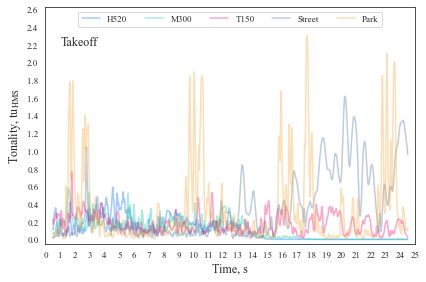

In [34]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet3'].iloc[13, 1:]
    # left channel
    specTonalityHMSL = pd.DataFrame(workbookdata['Sheet3'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet3'].iloc[13, 1:],
                                    index=workbookdata['Sheet3'].iloc[14:, 0])
    # right channel
    specTonalityHMSR = pd.DataFrame(workbookdata['Sheet4'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet4'].iloc[13, 1:],
                                    index=workbookdata['Sheet4'].iloc[14:, 0])
    # 2-channel time-varing tonality (max, not integration)
    tonalityHMSTimeVar2 = pd.concat([specTonalityHMSL.max(axis=0),
                                     specTonalityHMSR.max(axis=0)],
                                     axis=1)
    whichLR = np.argmax(tonalityHMSTimeVar2.mean(axis=0))
    tonalityHMSTimeVar = tonalityHMSTimeVar2.iloc[:, whichLR] 
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], tonalityHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 3, 0.2), xlim=[0, 25], ylim=[-0.05, 2.625],
       xlabel="Time, s", ylabel=r"Tonality, tu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=2.2, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtATonaltDepTakeoff.svg"), format='svg')
plt.show()

#### Fluctuation strength

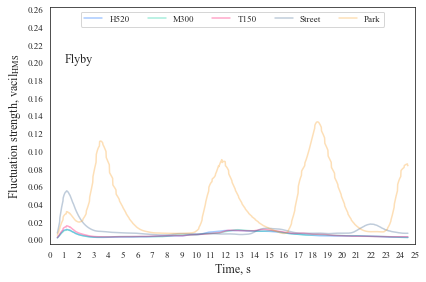

In [35]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet6'].iloc[13, 1:]
    # left channel
    specFluctStrHMSL = pd.DataFrame(workbookdata['Sheet6'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet6'].iloc[13, 1:],
                                    index=workbookdata['Sheet6'].iloc[14:, 0])
    # right channel
    specFluctStrHMSR = pd.DataFrame(workbookdata['Sheet7'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet7'].iloc[13, 1:],
                                    index=workbookdata['Sheet7'].iloc[14:, 0])
    # binaural specific fluctuation strength
    # (using ECMA-418-2:2022 Equation 112 for roughness)
    specFluctStrHMSBin = ((specFluctStrHMSL**2
                           + specFluctStrHMSR**2)/2).pow(1/2)
    # binaural time-dependent fluctuation strength
    # (using ECMA-418-2:2022 Equation 111 for roughness)
    fluctStrHMSTimeVar = specFluctStrHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], fluctStrHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.3, 0.02), xlim=[0, 25], ylim=[-0.005, 0.2625],
       xlabel="Time, s", ylabel=r"Fluctuation strength, vacil$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.2, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAFluctstDepFlyby.svg"), format='svg')
plt.show()

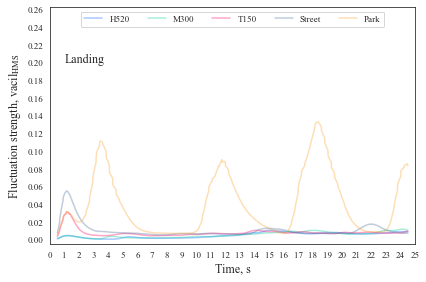

In [36]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet6'].iloc[13, 1:]
    # left channel
    specFluctStrHMSL = pd.DataFrame(workbookdata['Sheet6'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet6'].iloc[13, 1:],
                                    index=workbookdata['Sheet6'].iloc[14:, 0])
    # right channel
    specFluctStrHMSR = pd.DataFrame(workbookdata['Sheet7'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet7'].iloc[13, 1:],
                                    index=workbookdata['Sheet7'].iloc[14:, 0])
    # binaural specific fluctuation strength
    # (using ECMA-418-2:2022 Equation 112 for roughness)
    specFluctStrHMSBin = ((specFluctStrHMSL**2
                           + specFluctStrHMSR**2)/2).pow(1/2)
    # binaural time-dependent fluctuation strength
    # (using ECMA-418-2:2022 Equation 111 for roughness)
    fluctStrHMSTimeVar = specFluctStrHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], fluctStrHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.3, 0.02), xlim=[0, 25], ylim=[-0.005, 0.2625],
       xlabel="Time, s", ylabel=r"Fluctuation strength, vacil$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.2, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAFluctstDepLanding.svg"), format='svg')
plt.show()

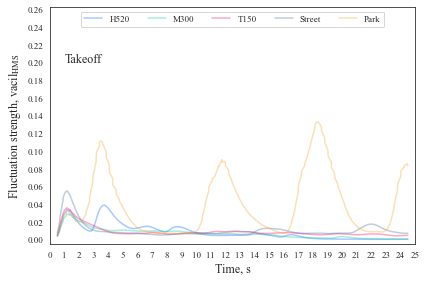

In [37]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet6'].iloc[13, 1:]
    # left channel
    specFluctStrHMSL = pd.DataFrame(workbookdata['Sheet6'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet6'].iloc[13, 1:],
                                    index=workbookdata['Sheet6'].iloc[14:, 0])
    # right channel
    specFluctStrHMSR = pd.DataFrame(workbookdata['Sheet7'].iloc[14:, 1:].values,
                                    columns=workbookdata['Sheet7'].iloc[13, 1:],
                                    index=workbookdata['Sheet7'].iloc[14:, 0])
    # binaural specific fluctuation strength
    # (using ECMA-418-2:2022 Equation 112 for roughness)
    specFluctStrHMSBin = ((specFluctStrHMSL**2
                           + specFluctStrHMSR**2)/2).pow(1/2)
    # binaural time-dependent fluctuation strength
    # (using ECMA-418-2:2022 Equation 111 for roughness)
    fluctStrHMSTimeVar = specFluctStrHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], fluctStrHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.3, 0.02), xlim=[0, 25], ylim=[-0.005, 0.2625],
       xlabel="Time, s", ylabel=r"Fluctuation strength, vacil$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.2, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAFluctstDepTakeoff.svg"), format='svg')
plt.show()

#### Roughness

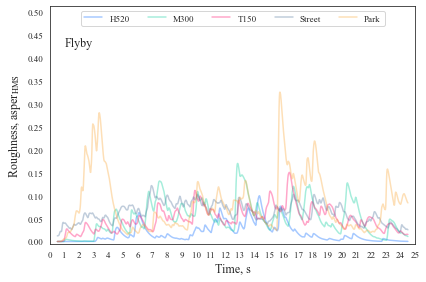

In [38]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet5'].iloc[13, 1:]
    # binaural specific roughness
    specRoughHMSBin = pd.DataFrame(workbookdata['Sheet5'].iloc[14:, 1:].values,
                                   columns=workbookdata['Sheet5'].iloc[13, 1:],
                                   index=workbookdata['Sheet5'].iloc[14:, 0])
    # binaural time-varying roughness
    roughHMSTimeVar = specRoughHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], roughHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.55, 0.05), xlim=[0, 25], ylim=[-0.005, 0.5125],
       xlabel="Time, s", ylabel=r"Roughness, asper$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.425, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtARoughtDepFlyby.svg"), format='svg')
plt.show()

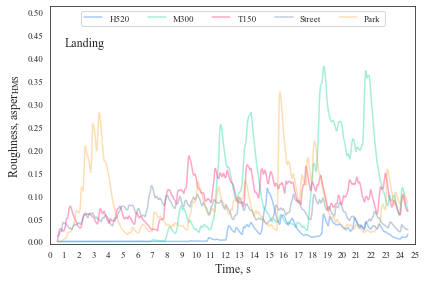

In [39]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet5'].iloc[13, 1:]
    # binaural specific roughness
    specRoughHMSBin = pd.DataFrame(workbookdata['Sheet5'].iloc[14:, 1:].values,
                                   columns=workbookdata['Sheet5'].iloc[13, 1:],
                                   index=workbookdata['Sheet5'].iloc[14:, 0])
    # binaural time-varying roughness
    roughHMSTimeVar = specRoughHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], roughHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.55, 0.05), xlim=[0, 25], ylim=[-0.005, 0.5125],
       xlabel="Time, s", ylabel=r"Roughness, asper$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.425, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtARoughtDepLanding.svg"), format='svg')
plt.show()

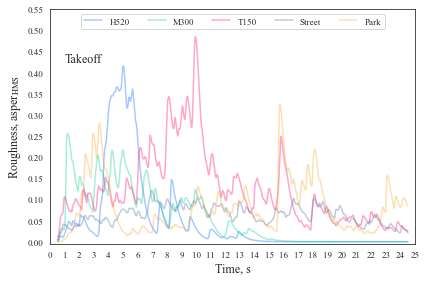

In [43]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet5'].iloc[13, 1:]
    # binaural specific roughness
    specRoughHMSBin = pd.DataFrame(workbookdata['Sheet5'].iloc[14:, 1:].values,
                                   columns=workbookdata['Sheet5'].iloc[13, 1:],
                                   index=workbookdata['Sheet5'].iloc[14:, 0])
    # binaural time-varying roughness
    roughHMSTimeVar = specRoughHMSBin.sum(axis=0)*0.5
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], roughHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 0.6, 0.05), xlim=[0, 25], ylim=[-0.005, 0.55],
       xlabel="Time, s", ylabel=r"Roughness, asper$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=1, y=0.425, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtARoughtDepTakeoff.svg"), format='svg')
plt.show()

#### Impulsiveness

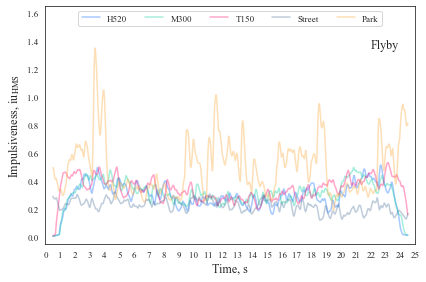

In [44]:
# flyby
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_F_1_SQM, M300_F_1_SQM, T150_F_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet12'].iloc[13:, 0]
    # 2-channel impulsiveness
    impulsiveHMSTimeVar2 = pd.DataFrame(workbookdata['Sheet12'].iloc[13:, 1:3].values,
                                       columns=workbookdata['Sheet12'].iloc[12, 1:3],
                                       index=workbookdata['Sheet12'].iloc[13:, 0])

    whichLR = np.argmax(impulsiveHMSTimeVar2.mean(axis=0))
    impulsiveHMSTimeVar = impulsiveHMSTimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], impulsiveHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 2, 0.2), xlim=[0, 25], ylim=[-0.05, 1.65],
       xlabel="Time, s", ylabel=r"Impulsiveness, iu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=22, y=1.35, s="Flyby", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAImpulstDepFlyby.svg"), format='svg')
plt.show()

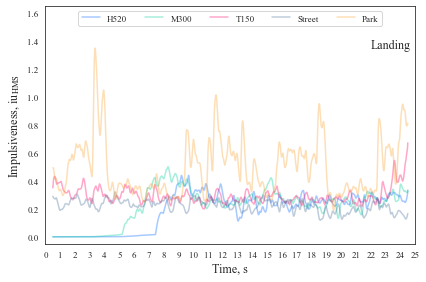

In [45]:
# landing
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_L_1_SQM, M300_L_1_SQM, T150_L_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet12'].iloc[13:, 0]
    # 2-channel impulsiveness
    impulsiveHMSTimeVar2 = pd.DataFrame(workbookdata['Sheet12'].iloc[13:, 1:3].values,
                                       columns=workbookdata['Sheet12'].iloc[12, 1:3],
                                       index=workbookdata['Sheet12'].iloc[13:, 0])

    whichLR = np.argmax(impulsiveHMSTimeVar2.mean(axis=0))
    impulsiveHMSTimeVar = impulsiveHMSTimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], impulsiveHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 2, 0.2), xlim=[0, 25], ylim=[-0.05, 1.65],
       xlabel="Time, s", ylabel=r"Impulsiveness, iu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=22, y=1.35, s="Landing", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAImpulstDepLanding.svg"), format='svg')
plt.show()

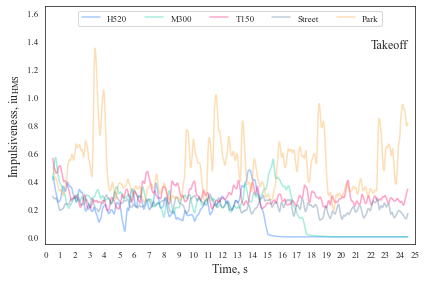

In [46]:
# takeoff
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_prop_cycle(cycler(color=mycolours))
labels = ["H520", "M300", "T150", "Street", "Park"]
for workbookdata in [H520_T_1_SQM, M300_T_1_SQM, T150_T_1_SQM, A1_SQM, A2_SQM]:
    t = workbookdata['Sheet12'].iloc[13:, 0]
    # 2-channel impulsiveness
    impulsiveHMSTimeVar2 = pd.DataFrame(workbookdata['Sheet12'].iloc[13:, 1:3].values,
                                       columns=workbookdata['Sheet12'].iloc[12, 1:3],
                                       index=workbookdata['Sheet12'].iloc[13:, 0])

    whichLR = np.argmax(impulsiveHMSTimeVar2.mean(axis=0))
    impulsiveHMSTimeVar = impulsiveHMSTimeVar2.iloc[:, whichLR]
    
    ax.plot(t[(t >= 0.5) & (t <= 24.5)], impulsiveHMSTimeVar[(t >= 0.5).values & (t <= 24.5).values], alpha=0.35)

ax.set(xticks=range(0, 26), yticks=np.arange(0, 2, 0.2), xlim=[0, 25], ylim=[-0.05, 1.65],
       xlabel="Time, s", ylabel=r"Impulsiveness, iu$_\text{HMS}$")
ax.legend(labels=labels, ncol=len(labels), loc='upper center')
ax.text(x=22, y=1.35, s="Takeoff", fontsize=12)
plt.savefig(os.path.join(outFigPath, "PtAImpulstDepTakeoff.svg"), format='svg')
plt.show()